# Computational Social Science Project #2 

**Enter your Name:** Mohammed Bello, Max Dunsker, Lara Pesce Ares, Ayesha Zafar, Alejandro Rodriguez

*Semester:* Fall 2025


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [39]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [40]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [41]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [42]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [43]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [44]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------

print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 

['No Data']


In [45]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [46]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype({'Diabetes_Number': 'int64'}) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype({'Obesity_Number': 'int64'}) 

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype({'Physical_Inactivity_Number': 'int64'}) 

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype("float64")


diabetes.dtypes

County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                           int64
Obesity_Number                                                                                                                                            int64
Physical_Inactivity_Number                                                                                                                                int64
sex and age_total population_65 years an

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [47]:
diabetes.head

<bound method NDFrame.head of                  County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001             5178           13489   
1        Baldwin County  Alabama      01003            16707           48542   
2        Barbour County  Alabama      01005             3400            8009   
3           Bibb County  Alabama      01007             2371            6534   
4         Blount County  Alabama      01009             6282           14227   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037             2560            9362   
3216       Teton County  Wyoming      56039              439            2051   
3217       Uinta County  Wyoming      56041             1440            4925   
3218    Washakie County  Wyoming      56043              637            1738   
3219      Weston County  Wyoming      56045              601            2015   

      Phy

In [48]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)


Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [49]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes[rc_cols].describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

count      mean  \
Diabetes_Number                                     3112.0  0.092857   
Obesity_Number                                      3112.0  0.251666   
Physical_Inactivity_Number                          3112.0  0.200861   
race_total population_one race                      3112.0  0.976059   
race_total population_two or more races             3112.0  0.023941   
race_total population_one race_1                    3112.0  0.976059   
race_total population_one race_white                3112.0  0.831107   
race_total population_one race_black or african...  3112.0  0.090215   
race_total population_one race_american indian ...  3112.0  0.019398   
race_total population_one race_american indian ...  3112.0  0.001791   
race_total population_one race_american indian ...  3112.0  0.001338   
race_total population_one race_american indian ...  3112.0  0.001229   
race_total population_one race_american indian ...  3112.0  0.003315   
race_total population_one race_asian                3112.0  0.013749   
race_total population_one race_asian_asian indian   3112.0  0.002628   
race_total population_one race_asian_chinese        3112.0  0.002644   
race_total population_one race_asian_filipino       3112.0  0.002744   
race_total population_one race_asian_japanese       3112.0  0.000707   
race_total population_one race_asian_korean         3112.0  0.001174   
race_total population_one race_asian_vietnamese     3112.0  0.001255   
race_total population_one race_asian_other asian    3112.0  0.002598   
race_total population_one race_native hawaiian ...  3112.0  0.000874   
race_total population_one race_native hawaiian ...  3112.0  0.000303   
race_total population_one race_native hawaiian ...  3112.0  0.000142   
race_total population_one race_native hawaiian ...  3112.0  0.000134   
race_total population_one race_native hawaiian ...  3112.0  0.000295   
race_total population_one race_some other race      3112.0  0.020716   
race_total population_two or more races_1           3112.0  0.023941   
race_total population_two or more races_white a...  3112.0  0.006444   
race_total population_two or more races_white a...  3112.0  0.008618   
race_total population_two or more races_white a...  3112.0  0.003021   
race_total population_two or more races_black o...  3112.0  0.000652   
race alone or in combination with one or more o...  3112.0  1.000000   
race alone or in combination with one or more o...  3112.0  0.852907   
race alone or in combination with one or more o...  3112.0  0.098875   
race alone or in combination with one or more o...  3112.0  0.029923   
race alone or in combination with one or more o...  3112.0  0.018213   
race alone or in combination with one or more o...  3112.0  0.002067   
race alone or in combination with one or more o...  3112.0  0.023626   
hispanic or latino and race_total population        3112.0  1.000000   
hispanic or latino and race_total population_hi...  3112.0  0.093201   
hispanic or latino and race_total population_hi...  3112.0  0.069331   
hispanic or latino and race_total population_hi...  3112.0  0.005656   
hispanic or latino and race_total population_hi...  3112.0  0.001568   
hispanic or latino and race_total population_hi...  3112.0  0.016645   
hispanic or latino and race_total population_no...  3112.0  0.906799   
hispanic or latino and race_total population_no...  3112.0  0.765065   
hispanic or latino and race_total population_no...  3112.0  0.088817   
hispanic or latino and race_total population_no...  3112.0  0.018016   
hispanic or latino and race_total population_no...  3112.0  0.013534   
hispanic or latino and race_total population_no...  3112.0  0.000780   
hispanic or latino and race_total population_no...  3112.0  0.001097   
hispanic or latino and race_total population_no...  3112.0  0.019489   
hispanic or latino and race_total population_no...  3112.0  0.000433   
hispanic or latino and race_total population_no...  3112.0  0.019056   
total housing units  

#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [50]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1',
 'sex and age_total population',
 'sex and age_total population_65 years and over_1',
 'race_total population_one race_1',
 'hispanic or latino and race_total population']

In [51]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [52]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


County    State CountyFIPS  Diabetes_Number  Obesity_Number  \
0        Autauga County  Alabama      01001         0.093804        0.244366   
1        Baldwin County  Alabama      01003         0.080281        0.233255   
2        Barbour County  Alabama      01005         0.131875        0.310643   
3           Bibb County  Alabama      01007         0.105251        0.290052   
4         Blount County  Alabama      01009         0.108977        0.246804   
...                 ...      ...        ...              ...             ...   
3215  Sweetwater County  Wyoming      56037         0.058028        0.212208   
3216       Teton County  Wyoming      56039         0.019038        0.088946   
3217       Uinta County  Wyoming      56041         0.069872        0.238973   
3218    Washakie County  Wyoming      56043         0.078361        0.213802   
3219      Weston County  Wyoming      56045         0.084648        0.283803   

      Physical_Inactivity_Number  \
0                       0.226902   
1                       0.192324   
2                       0.210651   
3                       0.258667   
4                       0.249198   
...                          ...   
3215                    0.170410   
3216                    0.086951   
3217                    0.170751   
3218                    0.210112   
3219                    0.194789   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                                  76.5                                  
1                                                  86.6                                  
2                                                  76.2                                  
3                                                  80.5                                  
4                                                  79.7                                  
...                                                 ...                                  
3215                                               92.0                                  
3216                                               94.8                                  
3217                                               97.6                                  
3218                                               89.0                                  
3219                                               90.6                                  

      race_total population  race_total population_one race  \
0                     55200                        0.981341   
1                    208107                        0.982836   
2                     25782                        0.986308   
3                     22527                        0.991699   
4                     57645                        0.983780   
...                     ...                             ...   
3215                  44117                        0.979804   
3216                  23059                        0.992020   
3217                  20609                        0.965161   
3218                   8129                        0.958420   
3219                   7100                        0.979718   

      race_total population_two or more races  \
0                                    0.018659   
1                                    0.017164   
2                                    0.013692   
3                                    0.008301   
4                                    0.016220   
...                                       ...   
3215                                 0.020196   
3216                                 0.007980   
3217                                 0.034839   
3218                                 0.041580   
3219                                 0.020282   

      race_total population_one race_white  \
0                                 0.768786   
1                                 0.862662   
2                                 0.473819   
3           

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

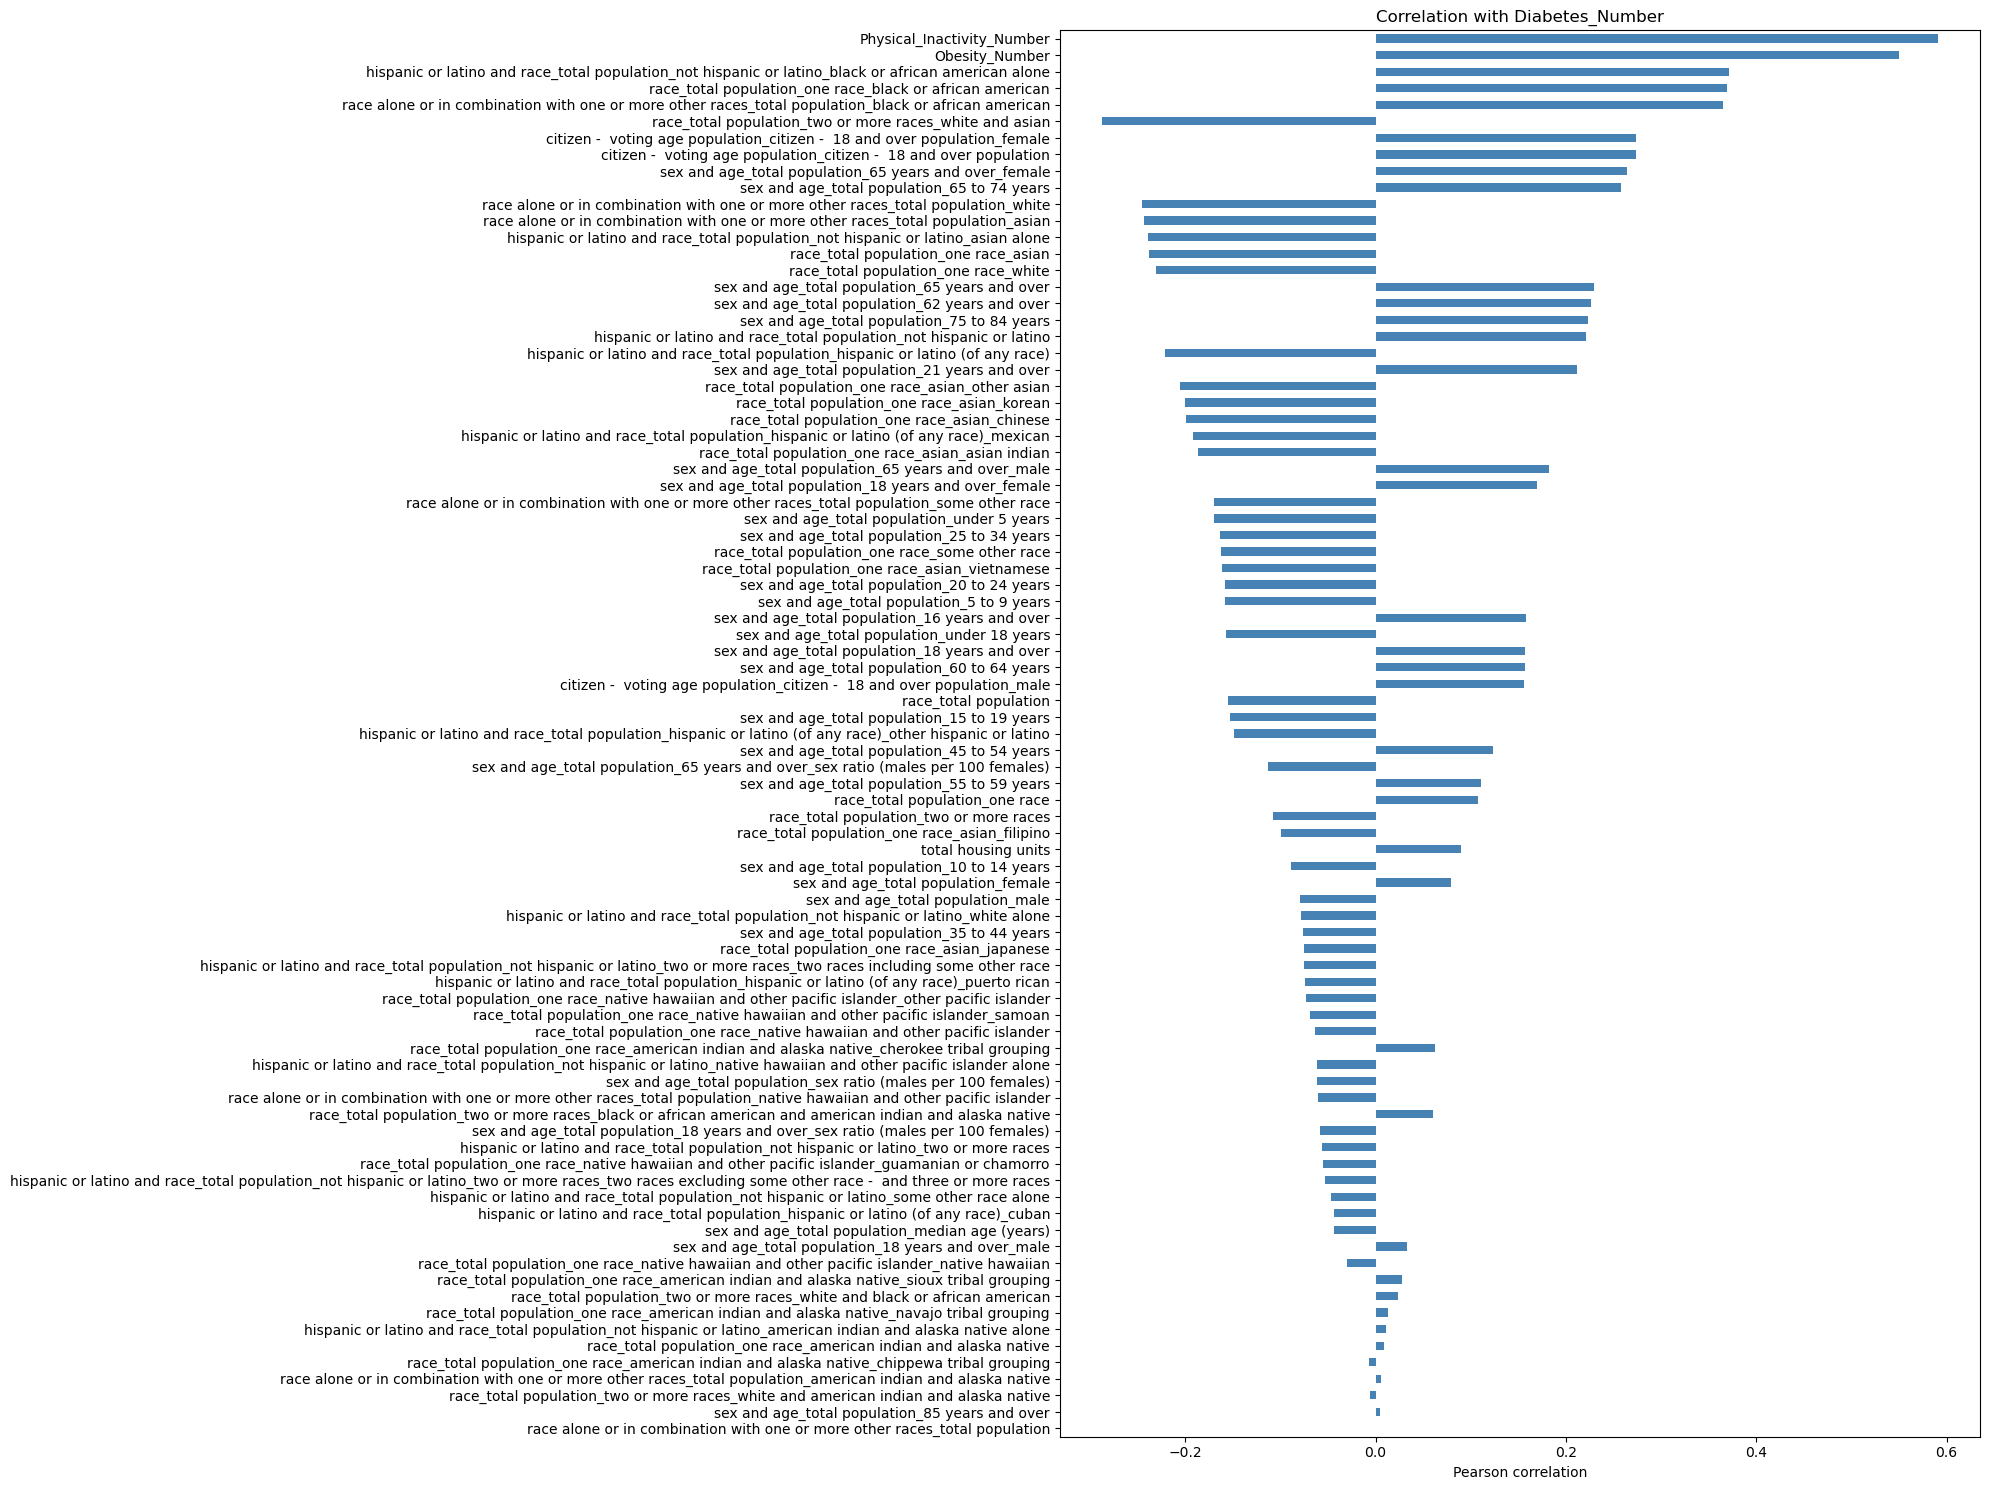

In [53]:
#
# EDA #1 and interpretations in this section 
#-----------
# Box Plot showing variation among counties accross all our variables
import matplotlib.pyplot as plt

cols_box = [
    'Diabetes_Number',
    'Physical_Inactivity_Number',
    'Obesity_Number',
    'race_total population_one race_white',
    'race_total population_one race_black or african american',
    'race_total population_one race_asian',
    'race_total population_two or more races',  # <- multiracial column
    'hispanic or latino and race_total population_hispanic or latino (of any race)',
    'hispanic or latino and race_total population_not hispanic or latino',
    'citizen - voting age population_citizen - 18 and over population',
    'sex and age_total population_median age (years)',
    'sex and age_total population_male',
    'sex and age_total population_female'
]

# Filter to only existing columns
# cols_box = [c for c in cols_box if c in diabetes.columns]
cols_box = [c for c in diabetes.columns]

# --- Correlation bar chart of selected high-level variables ---
target = "Diabetes_Number"
exclude = ["Diabetes_Number", "State", "Region", "County", "CountyFIPS"]
corr = (
    diabetes[cols_box].select_dtypes (include = "number")
    .corr()[target]
    .drop(target)
    .sort_values(key=lambda s: s.abs(), ascending=False)
)

plt.figure(figsize=(20, 15))
corr.plot(kind="barh", color="steelblue")
plt.gca().invert_yaxis()
plt.title("Correlation with Diabetes_Number")
plt.xlabel("Pearson correlation")
plt.tight_layout()
plt.show()

### **EDA 1 Results:**
This chart aims to understand how each variable relates to the incidence of diabetes to understand potential causal mechanisms.

The correlation analysis highlights clear relationships between diabetes prevalence and several demographic variables. Within each county, the strongest positive correlations are with physical inactivity and obesity, confirming well-established links between these factors and diabetes risk. These two variables stand out as the most powerful predictors and should be central to any predictive modeling or policy intervention strategy.

Racial statistics also have strong correlations. The strongest negative correlations are on the variables that indicate a high proportion of white or Asian people in the county population. This suggests that diabetes is more prevalent in areas with fewer white and asian people as a percentage of the population. Meanwhile, there are very strong positive correlations with the percentage of Black residents. 

Age may also play a role: counties with more adults and more elderly adults as a percentage of the population have higher rates of diabetes. However, this may be explained by the role that lifestyle factors that accumulate over time play a role in the development of diabetes as a medical condition.

<Figure size 1200x2000 with 0 Axes>

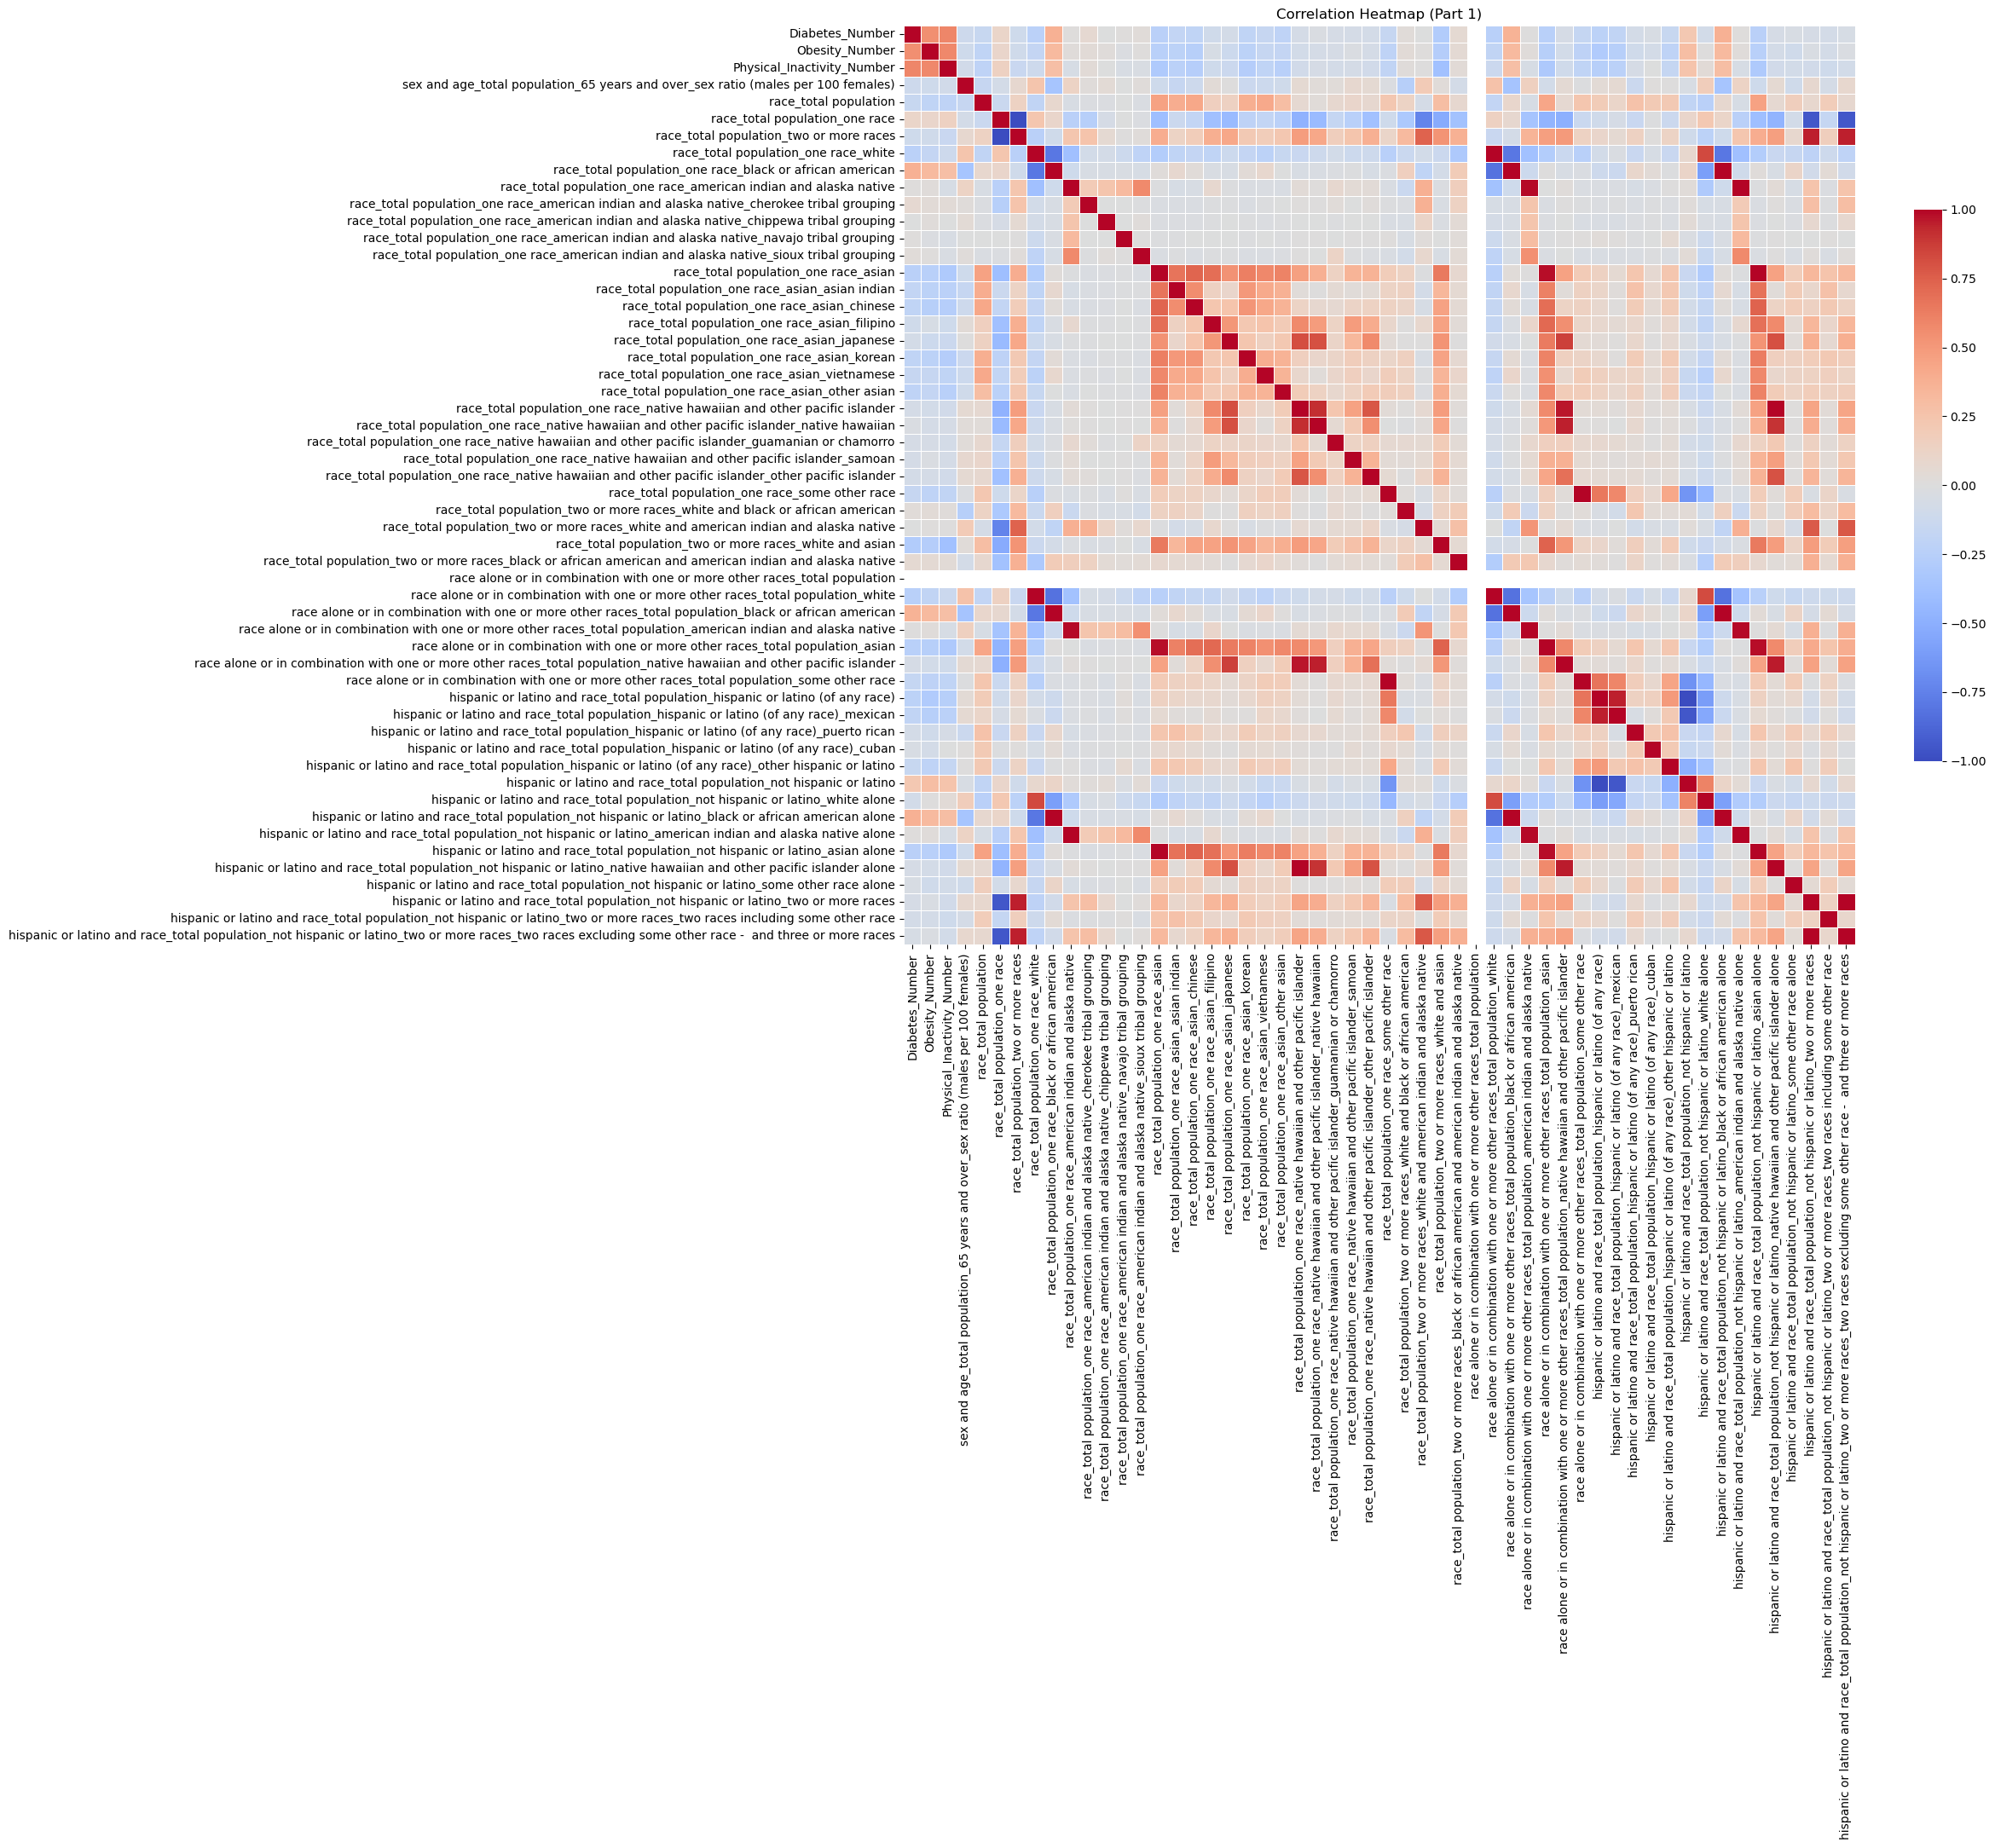

In [54]:
#
# EDA #2 and interpretations in this section 
#Correlation Heatmap between all numeric variables
# Only numeric values
diabetesNum = diabetes.select_dtypes(include=["float64", "int64"]).copy()

plt.figure(figsize=(12,20))
corr = diabetesNum.corr()
col_split = "hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races"

# Find index of the split column
split_index = list(corr.columns).index(col_split)

# Heatmap 1: from column 1 to split_index
corr_part1 = corr.iloc[:split_index+1, :split_index+1]
plt.figure(figsize=(18, 14))
sns.heatmap(corr_part1, cmap="coolwarm", center=0, linewidths=0.5, cbar_kws={"shrink": 0.6},)
plt.title("Correlation Heatmap (Part 1)")
plt.show()

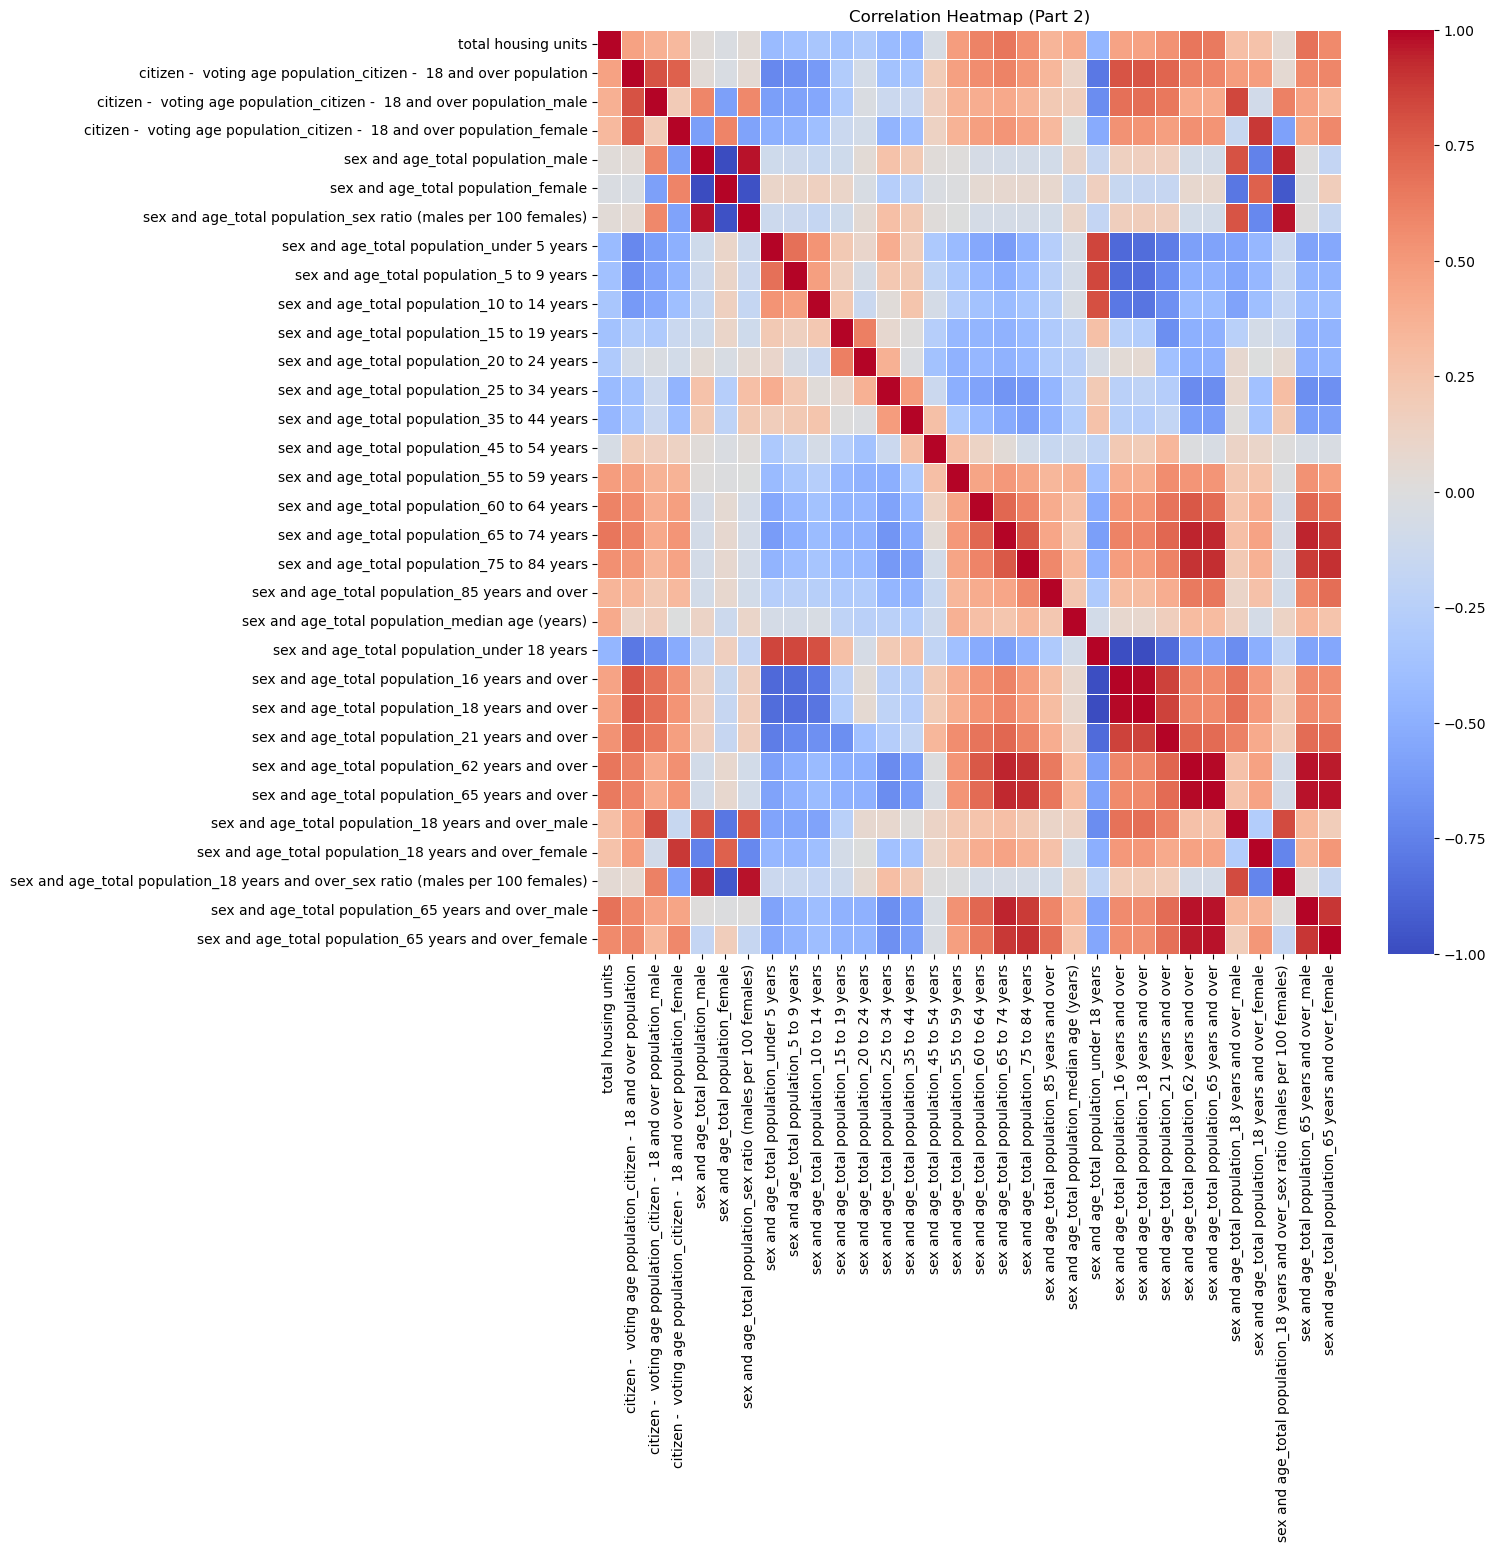

In [55]:
# Heatmap 2: from split_index+1 to end
corr_part2 = corr.iloc[split_index+1:, split_index+1:]
plt.figure(figsize=(12, 12))
sns.heatmap(corr_part2, cmap="coolwarm", center=0,  linewidths=0.5,)
plt.title("Correlation Heatmap (Part 2)")
plt.show()

### **EDA 2 Results:**

This chart aims to understand how the variables relate to one another in order to guide decisions made during the modelling process.

We find that the percentage of the county population within a racial subgroup, such as Asian people of Chinese descent, generally tracks very closely with the percentage of the county population in that racial group, in this case Asian. This is true for Asian, Native Hawaiian and Pacific Islander, and American Indian and Alaska Native racial groups. As a result, we feel comfortable excluding many of these racial subgroups from the analysis in order to focus more on the relationship between diabetes incidence and the percentage of the population in the wider racial group. A more technical explanation of the justification is included below.

The correlation heatmap reveals substantial collinearity across demographic and population features, especially among race and age variables, meaning that they show a strong relationship to one another. Many subcategories of race (e.g., Hispanic or Latino subgroups, or racial breakdowns within “one race” categories) show correlations near +1 or −1, meaning they convey almost identical or perfectly inverse information. For example, features like “race_total population_one race_white” and “race_total population_two or more races” are nearly perfectly inversely correlated, indicating redundancy. 
Similarly, several age and gender population counts are highly correlated, since each represents slightly segments of the same total population. This redundancy implies that including all these variables in a traditional regression model violate some key model assumptions.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [56]:
# MAX
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 


# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

diabetes_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3112 entries, 0 to 3219
Data columns (total 91 columns):
 #   Column                                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                                --------------  -----  
 0   CountyFIPS                                                                                                                                            3112 non-null   object 
 1   Diabetes_Number                                                                                                                                       3112 non-null   float64
 2   Obesity_Number                                                                                                                                        3112 non-null   float64
 3 

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [57]:
# ALE
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1) # refers to columns

# preview these changes in the data
X.head(10)

CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   
5      01011        0.353748                    0.321967   
6      01013        0.349513                    0.300974   
7      01015        0.298580                    0.234140   
8      01017        0.324425                    0.220570   
9      01019        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_one race  \
0                  55200                        0.981341   
1                 208107                        0.982836   
2                  25782                        0.986308   
3                  22527                        0.991699   
4                  57645                        0.983780   
5                  10352                        1.000000   
6                  20025                        0.983870   
7                 115098                        0.976229   
8                  33826                        0.989742   
9                  25853                        0.991955   

   race_total population_two or more races  \
0                                 0.018659   
1                                 0.017164   
2                                 0.013692   
3                                 0.008301   
4                                 0.016220   
5                                 0.000000   
6                                 0.016130   
7                                 0.023771   
8                                 0.010258   
9                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.049008          

   race_total population_one race_american indi

In [58]:
X.shape

(3112, 90)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [59]:
# ALE
# Feature selection
#-----------
# Use the colinearity EDA to identify the most related variables and remove them as features
# Ask Annette: Should we be deleting very similar variables or the non-relevant subgroups? 
# Anette's answer: you can drop the small subgroups and see how the different models perform dealing with multicolinearity
X = diabetes_clean.drop(labels = ['race_total population_one race', 
                                 'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
                                  'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
                                  'race_total population_one race_american indian and alaska native_navajo tribal grouping',
                                  'race_total population_one race_american indian and alaska native_navajo tribal grouping',
                                  'race_total population_one race_american indian and alaska native_sioux tribal grouping',
                                  'race_total population_one race_asian_asian indian',
                                  'race_total population_one race_asian_chinese',
                                  'race_total population_one race_asian_filipino',
                                  'race_total population_one race_asian_japanese',
                                  'race_total population_one race_asian_korean',
                                  'race_total population_one race_asian_vietnamese',
                                  'race_total population_one race_asian_other asian',
                                  'race_total population_one race_native hawaiian and other pacific islander_native hawaiian',
                                  'race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro',
                                  'race_total population_one race_native hawaiian and other pacific islander_samoan',
                                  'race_total population_one race_native hawaiian and other pacific islander_other pacific islander',
                                  'race alone or in combination with one or more other races_total population',
                                  'hispanic or latino and race_total population_hispanic or latino (of any race)_mexican',
                                  'hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican',
                                  'hispanic or latino and race_total population_hispanic or latino (of any race)_cuban',
                                  'hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino',
                                  'hispanic or latino and race_total population_not hispanic or latino_white alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_black or african american alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_asian alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_some other race alone',
                                  'hispanic or latino and race_total population_not hispanic or latino_two or more races',
                                  'citizen -  voting age population_citizen -  18 and over population_male',
                                  'citizen -  voting age population_citizen -  18 and over population_female',
                                  'sex and age_total population_sex ratio (males per 100 females)',
                                  'sex and age_total population_18 years and over_male',
                                  'sex and age_total population_18 years and over_female',
                                  'sex and age_total population_18 years and over_sex ratio (males per 100 females)',
                                  'Diabetes_Number'
                                 ],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
X.head(10) 


CountyFIPS  Obesity_Number  Physical_Inactivity_Number  \
0      01001        0.244366                    0.226902   
1      01003        0.233255                    0.192324   
2      01005        0.310643                    0.210651   
3      01007        0.290052                    0.258667   
4      01009        0.246804                    0.249198   
5      01011        0.353748                    0.321967   
6      01013        0.349513                    0.300974   
7      01015        0.298580                    0.234140   
8      01017        0.324425                    0.220570   
9      01019        0.300429                    0.237342   

   sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
0                                               76.5                                  
1                                               86.6                                  
2                                               76.2                                  
3                                               80.5                                  
4                                               79.7                                  
5                                               73.6                                  
6                                               69.1                                  
7                                               73.7                                  
8                                               73.3                                  
9                                               86.7                                  

   race_total population  race_total population_two or more races  \
0                  55200                                 0.018659   
1                 208107                                 0.017164   
2                  25782                                 0.013692   
3                  22527                                 0.008301   
4                  57645                                 0.016220   
5                  10352                                 0.000000   
6                  20025                                 0.016130   
7                 115098                                 0.023771   
8                  33826                                 0.010258   
9                  25853                                 0.008045   

   race_total population_one race_white  \
0                              0.768786   
1                              0.862662   
2                              0.473819   
3                              0.766547   
4                              0.955052   
5                              0.219861   
6                              0.520050   
7                              0.743349   
8                              0.575977   
9                              0.928209   

   race_total population_one race_black or african american  \
0                                           0.191395          
1                                           0.094970          
2                                           0.475758          
3                                           0.222755          
4                                           0.014954          
5                                           0.762461          
6                                           0.452185          
7                                           0.205703          
8                                           0.393750          
9                                           0.049008          

   race_total population_one race_american indian and alaska native  \
0                                           0.002880                  
1                                           0.007314                  
2                                           0.002793                  
3                                           0.000355                  
4                                           0.002446                  
5                            

### **Preparing data for modelling, key assumptions**

To reduce redundancy and improve model interpretability, several features were removed prior to model fitting. Many of these variables represented highly disaggregated or overlapping demographic subgroups (e.g., detailed race and ethnicity breakdowns, gender splits within age or citizenship categories) that were strongly correlated with broader aggregates. Including all of them would introduce multicollinearity and add little new information. Additionally, the variable Diabetes_Number was dropped due to potential target leakage, as it directly reflects the outcome the model aims to predict. This feature selection step helps simplify the dataset while retaining the most informative predictors for robust and unbiased modeling.

In [60]:
X.shape

(3112, 56)

In [61]:
# ALE 
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.80,      # specify proportional split for training
                                                    test_size=0.20)       # specify proportional split for test

In [62]:
# print shape of each newly created dataframe
print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)

# verify proportional splits
print("100% of original dataset", X.shape[0])
print("80% of full dataset", X.shape[0]*.8)
print("20% of full dataset", X.shape[0]*.2)

Shape of X train is (2489, 56)
Shape of y_train is (2489,)
Shape of X_test is (623, 56)
Shape of y_test is (623,)
100% of original dataset 3112
80% of full dataset 2489.6000000000004
20% of full dataset 622.4000000000001


In [63]:
# ALE
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,         # specify training x
                                                            y_train,         # specify training y
                                                            train_size=0.75, # set training proportional spilt
                                                            test_size=0.25)  # set testing proportional split

In [64]:
# print shape of each newly created dataframe
print("Shape of X train is", X_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of X_test is", X_test.shape)

# verify proportional splits
print("100% of original dataset", X.shape[0])
print("60% of full dataset", X.shape[0]*.6)
print("20% of full dataset", X.shape[0]*.2)

Shape of X train is (1866, 56)
Shape of X_validate is (623, 56)
Shape of X_test is (623, 56)
100% of original dataset 3112
60% of full dataset 1867.1999999999998
20% of full dataset 622.4000000000001


### **Key methodological information to understand as a policymaker**

The dataset was randomly partitioned into three subsets to ensure model evaluation. Eighty percent of the data was allocated to the training set and twenty percent to the test set. From the training data, 25% was further set aside as a validation set (equivalent to 20% of the total data).

The training set is used to fit the model and learn underlying patterns in the data. The validation set is used for model tuning, hyperparameter optimization, and prevent overfitting by evaluating performance on unseen data during training. The test set provides an unbiased final assessment of model generalization.

Using most data for training improves learning, while keeping sufficient data for validation and testing ensures that evaluation metrics are statistically meaningful and generalizable.

In [65]:
# ALE
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# Standardizing after train/test split to ensure no cross-contamination between the training and testing datasets

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()


## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

#### **MODEL DESCRIPTIONS:**

##### Linear Regression 

Ordinary Least Squares (OLS) estimates a straight-line relationship between the dependent variable and all predictors by minimizing the sum of squared residuals. It assumes linearity, independence of errors, constant error variance (homoscedasticity), and no perfect multicollinearity among predictors. The model’s simplicity makes it easy to interpret because each coefficient shows the marginal change in the outcome for a one-unit change in that feature. However, it can overfit when predictors are highly correlated and underperform when relationships are nonlinear. Because the goal here is to establish a transparent baseline and gauge how strongly socioeconomic and health-related variables relate to diabetes outcomes, OLS is a natural starting point.

##### Ridge Regression 

Ridge adds an L2 penalty (the squared magnitude of coefficients) to the OLS loss function. This shrinks coefficients toward zero but never exactly to zero, stabilizing estimates when predictors are correlated or when there are many more features than independent observations. Ridge retains all predictors but controls their influence, trading a small amount of bias for lower variance and improved out-of-sample performance. It assumes the same linearity and error conditions as OLS but is more robust under multicollinearity. Because the dataset contains many demographic and regional variables that may be correlated, Ridge is a plausible choice to improve predictive reliability and interpretability.

##### LASSO Regression 

LASSO (Least Absolute Shrinkage and Selection Operator) uses an L1 penalty, summing the absolute values of coefficients. This form of regularization not only shrinks coefficients but can drive some exactly to zero, performing implicit feature selection. It shares OLS’s core assumptions of linearity and additive effects, but is especially useful when we suspect only a subset of predictors meaningfully explain the outcome. Its main drawback is potential instability when predictors are highly correlated. LASSO may pick one variable arbitrarily and ignore the others, but it provides a sparse, interpretable model that highlights the strongest determinants of diabetes rates.


### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### **Model 1: Linear Regression**


--- Linear Regression Coefficients ---


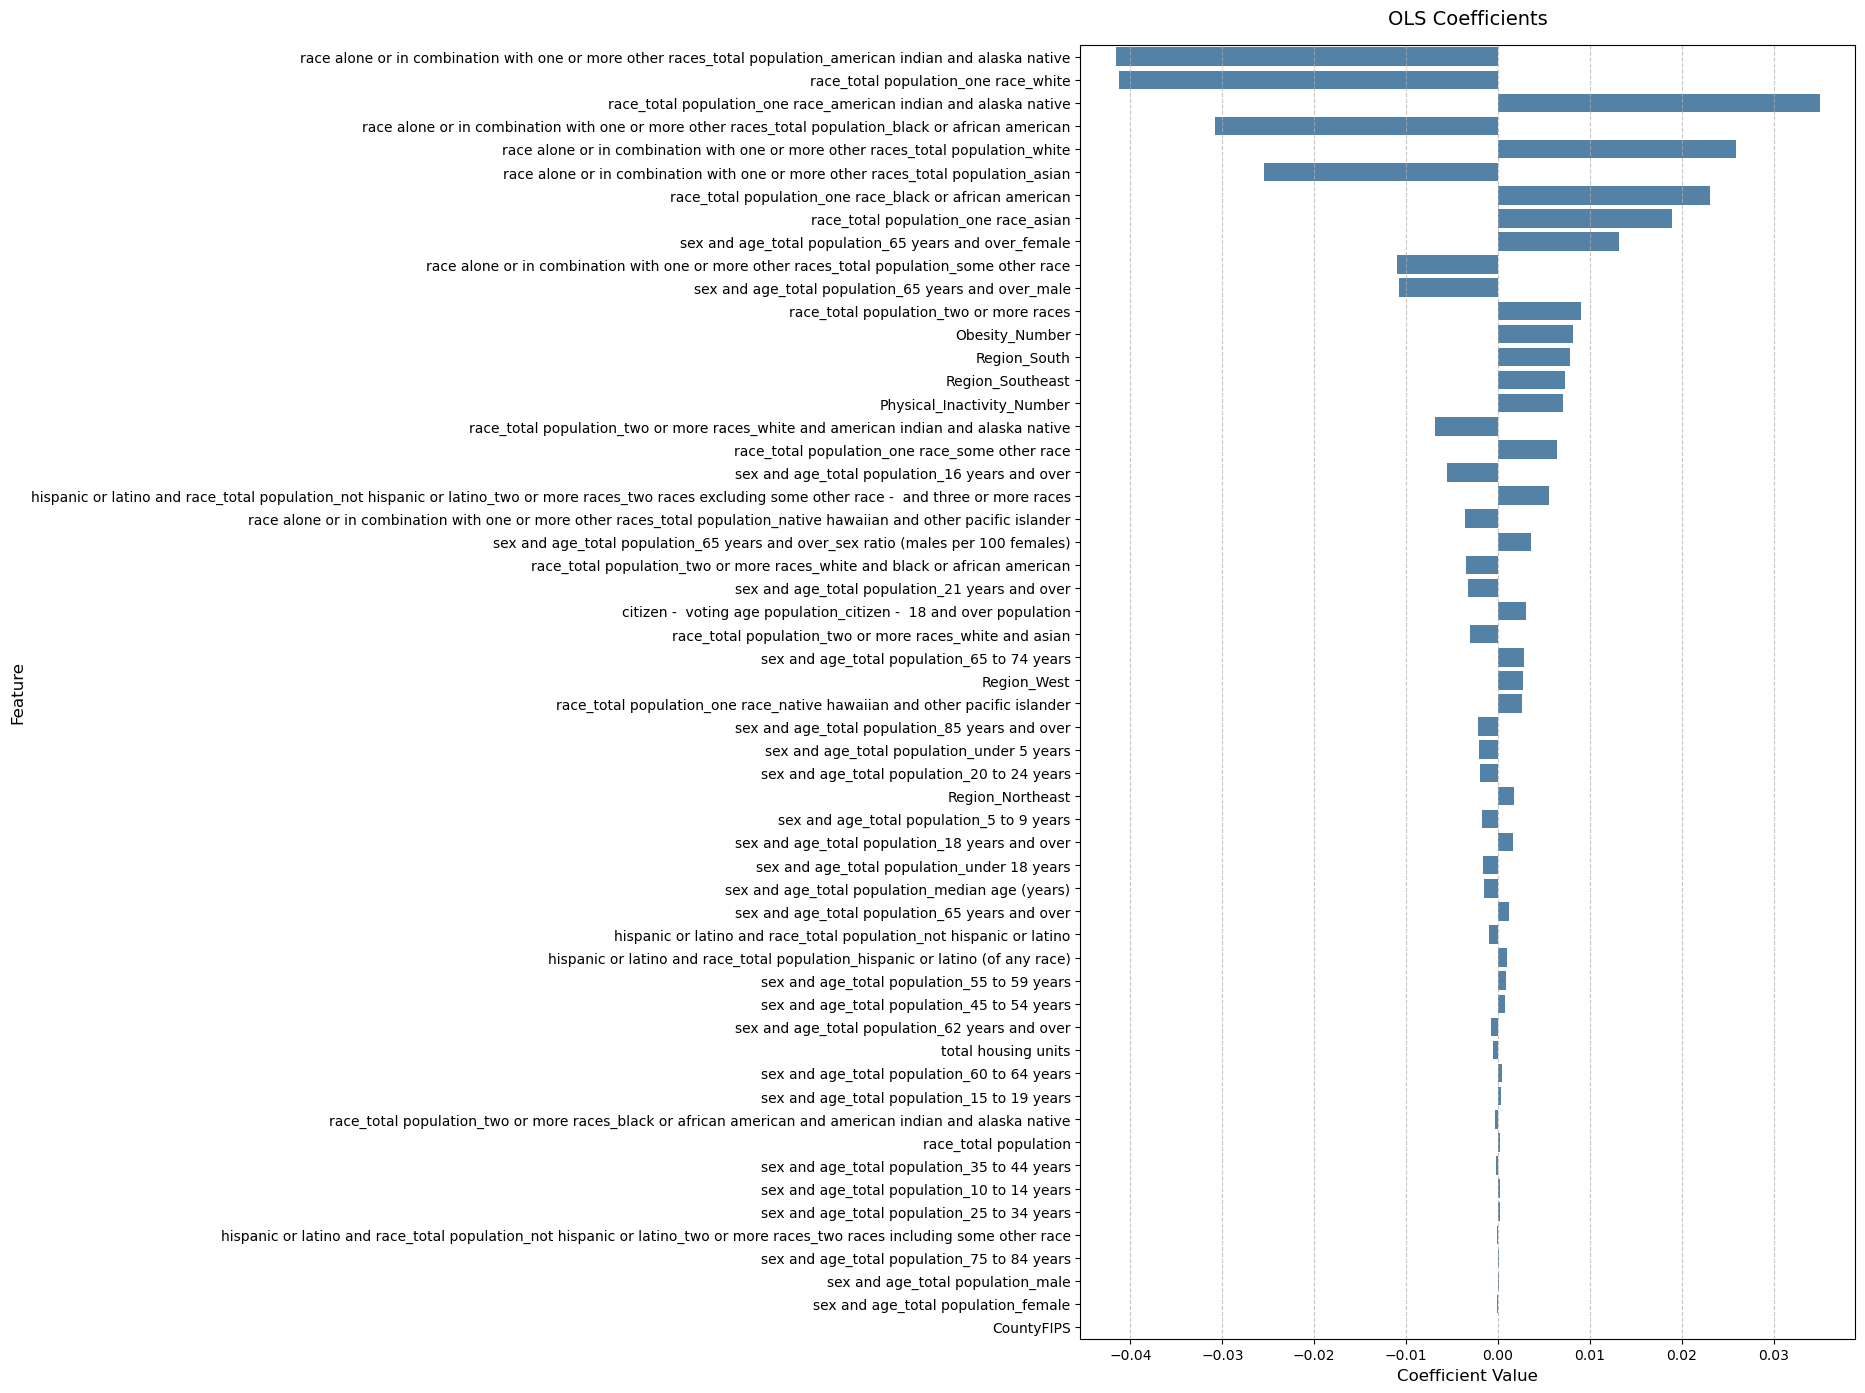

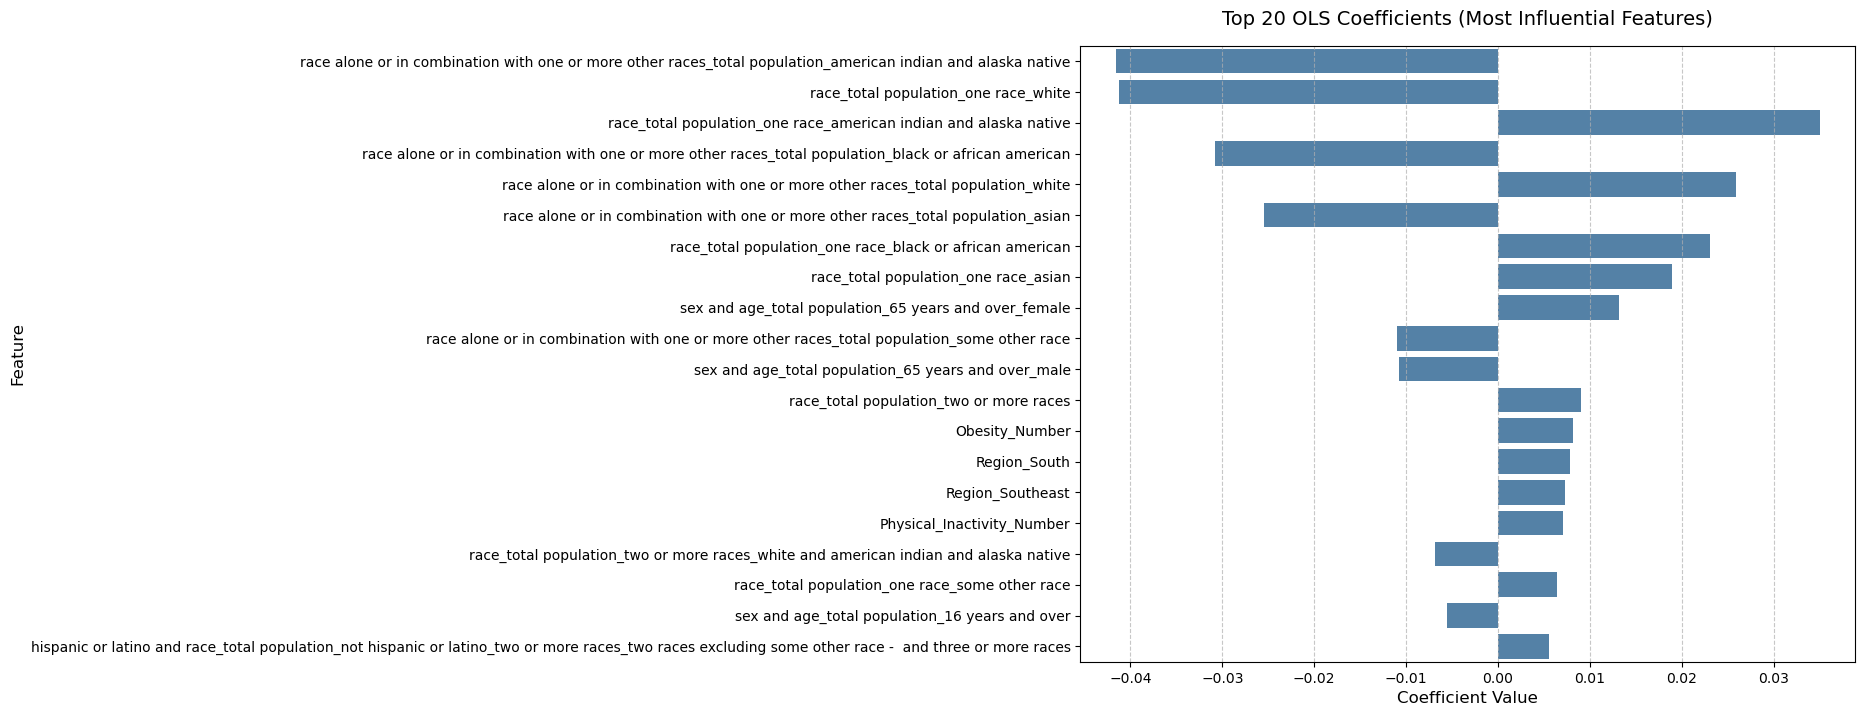

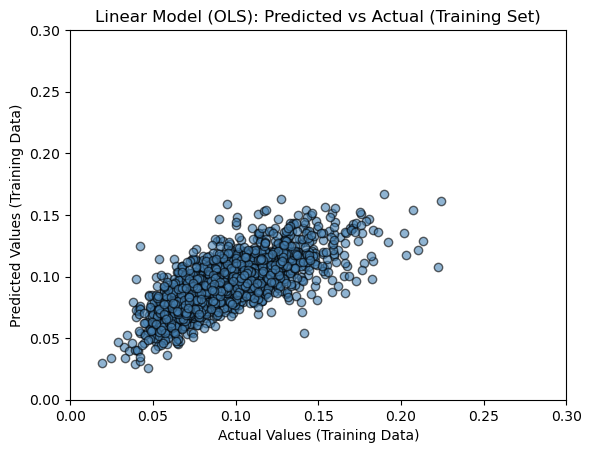


Linear Regression (Training Set):
R²: 0.5345
RMSE: 0.0197


In [66]:
# -----------------------------------------------------------
# LINEAR REGRESSION MODEL (ORDINARY LEAST SQUARES)
# -----------------------------------------------------------

# Initializing the Linear Regression model using sklearn.
lin_reg = LinearRegression()

# Fitting the model using the training data.
lin_model = lin_reg.fit(X_train, 
                        y_train)

# Creating a DataFrame that pairs each feature name with its corresponding coefficient
print("\n--- Linear Regression Coefficients ---")
lin_reg_data = pd.DataFrame([lin_model.coef_,
                             X.columns]).T

lin_reg_data.columns = ['Coefficient',
                        'Feature']


# --------------- Visualising Coefficients --------------- 

# Sorting Values by Magnitude (Abs)
lin_reg_data = lin_reg_data.sort_values(by="Coefficient", key=abs, ascending=False)

plot_height = max(6, 0.3 * len(lin_reg_data))
plt.figure(figsize=(10, plot_height))


ax = sns.barplot(
    x="Coefficient",
    y="Feature",
    data=lin_reg_data,
    color="steelblue"
)

ax.set_title("OLS Coefficients", fontsize=14, pad=15)
ax.set_xlabel("Coefficient Value", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plotting a second graph with Top 20 coefficients for readability and to see the most influential features 
plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficient", y="Feature", data=lin_reg_data.head(20), color="steelblue")
plt.title("Top 20 OLS Coefficients (Most Influential Features)", fontsize=14, pad=15)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ----- Summary Statistics -----

# Testing how well each model fits the training data. 
y_train_pred_lin = lin_model.predict(X_train)

#Plotting the training data against prediction
plt.scatter(y_train, y_train_pred_lin, color='steelblue', alpha=0.6, edgecolor='k')
plt.title('Linear Model (OLS): Predicted vs Actual (Training Set)')
plt.xlabel('Actual Values (Training Data)')
plt.ylabel('Predicted Values (Training Data)')
plt.xlim (0, 0.3)
plt.ylim (0, 0.3)
plt.show()


# Computing R² on training set
r2_train_lin = r2_score(y_train, y_train_pred_lin)

# Computing RMSE on training set
rmse_train_lin = np.sqrt(mean_squared_error(y_train, y_train_pred_lin))

print("\nLinear Regression (Training Set):")
print("R²:", round(r2_train_lin, 4))
print("RMSE:", round(rmse_train_lin, 4))


#### Model 2:  Ridge Regression


--- Ridge Regression Coefficients ---


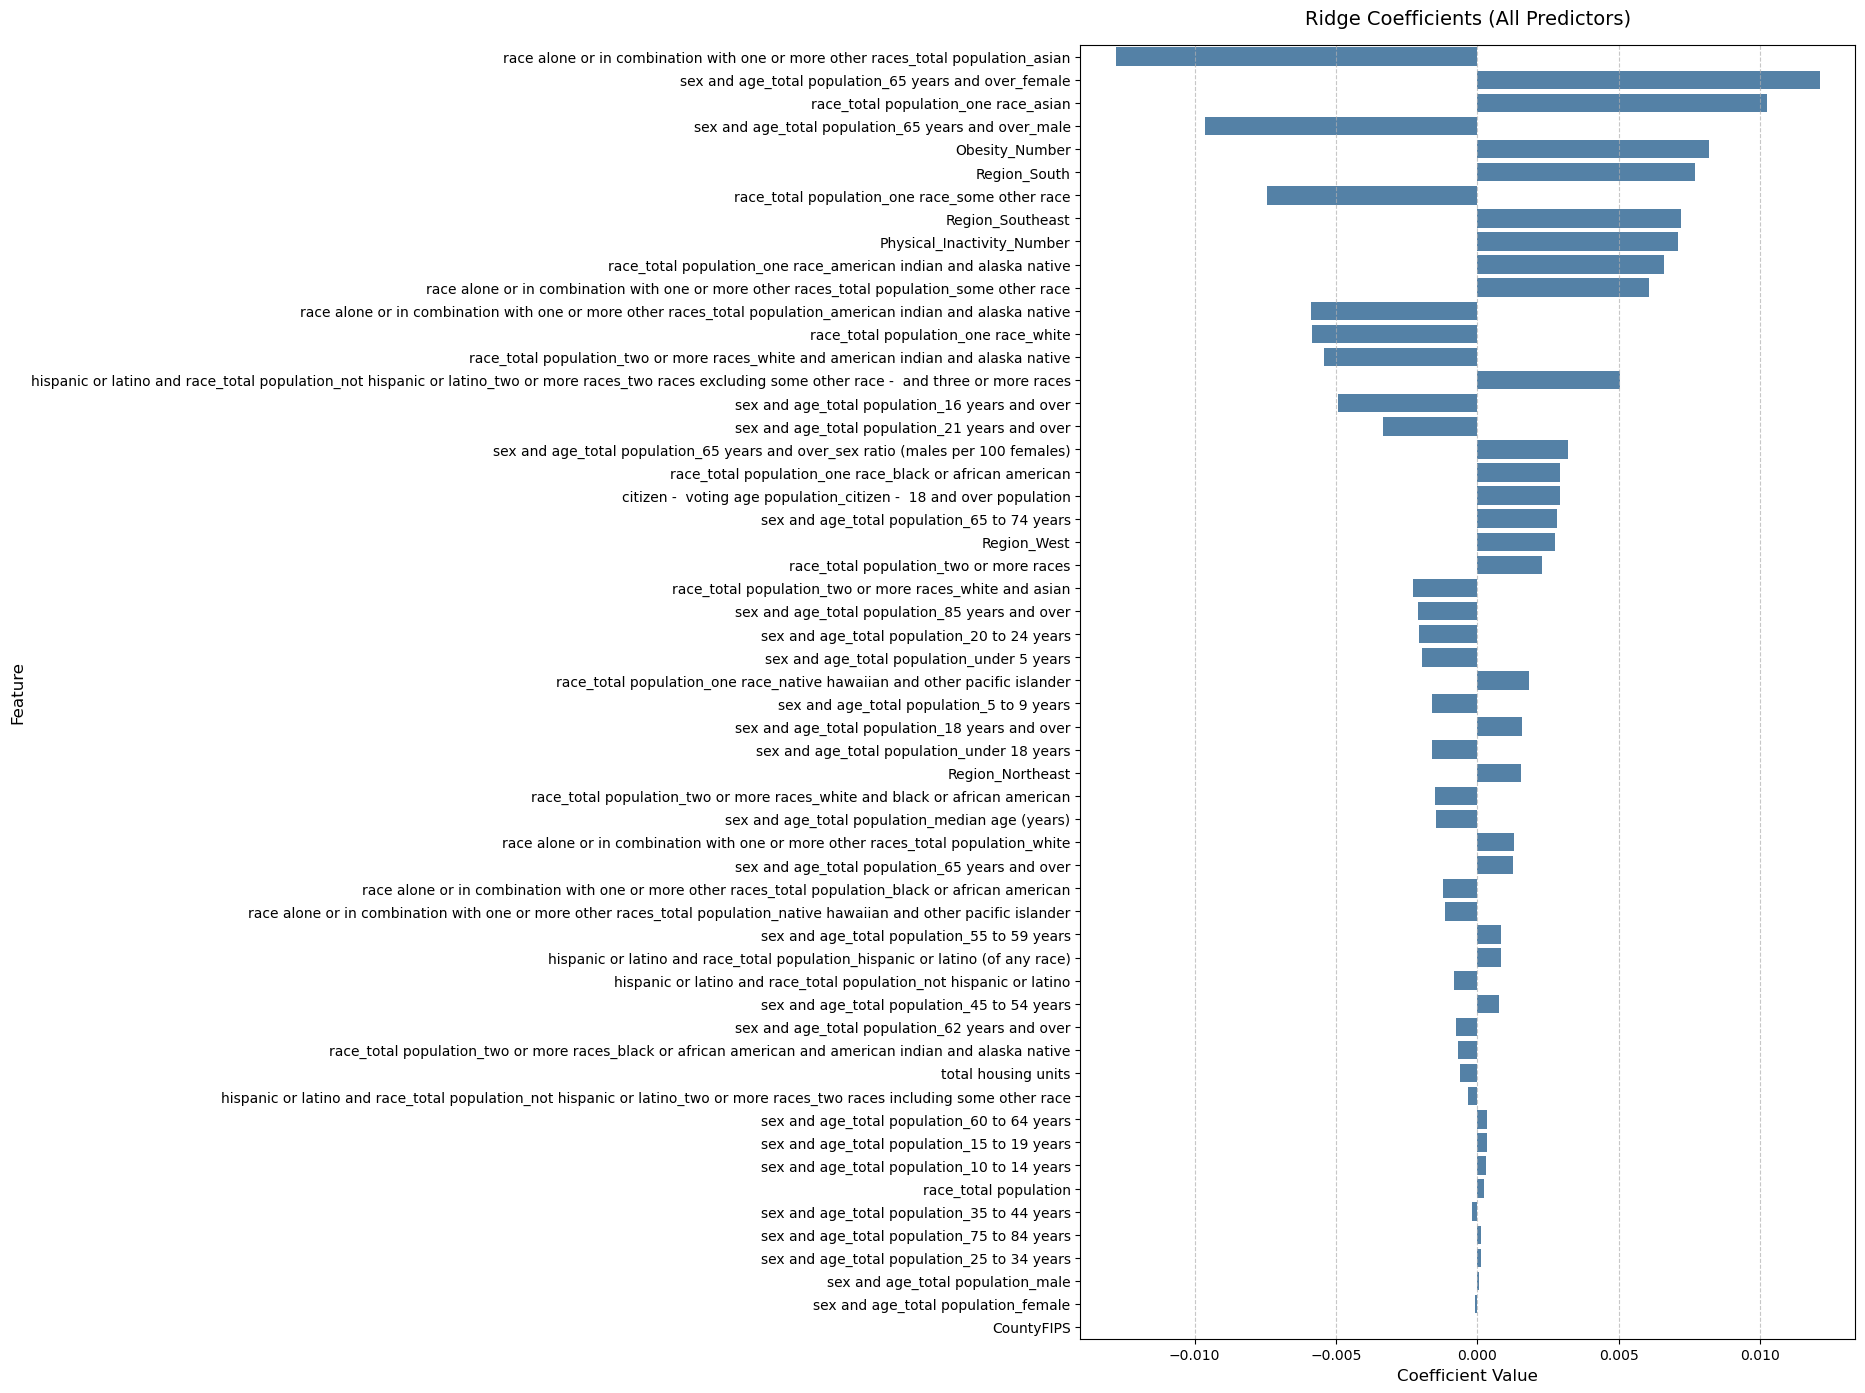

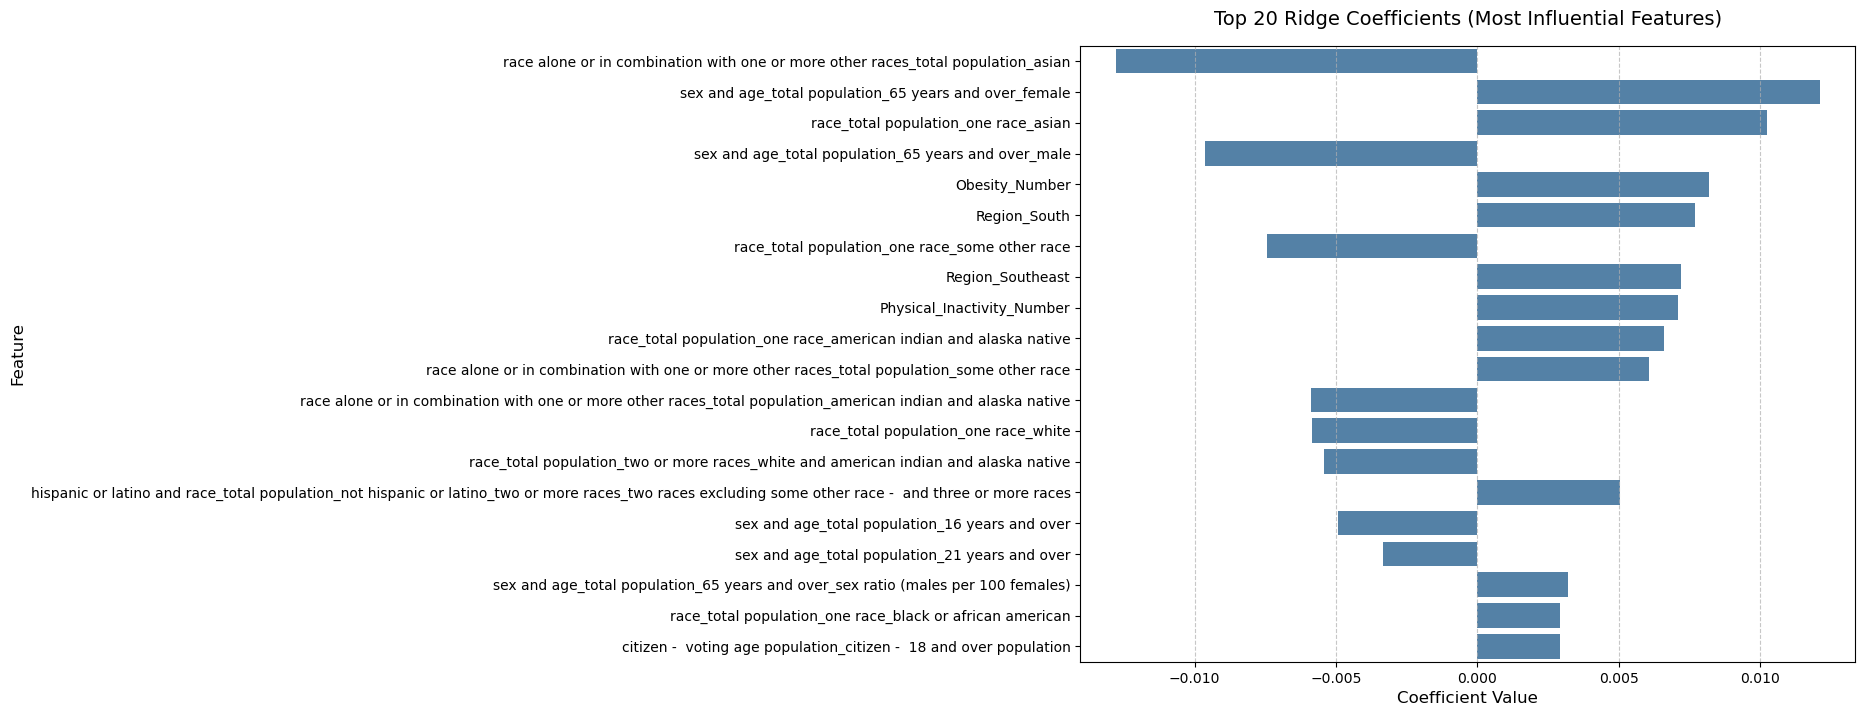

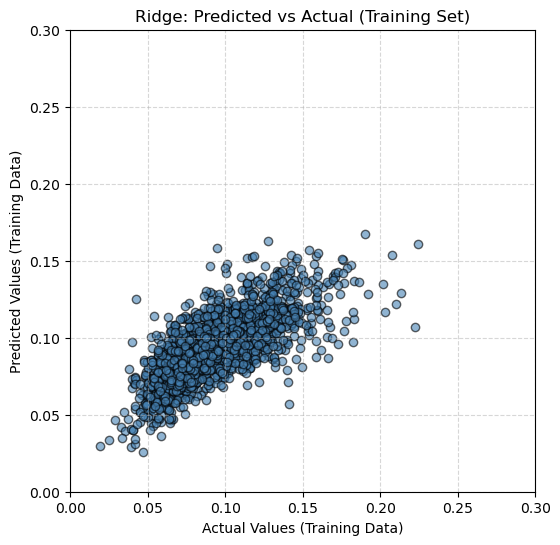


Ridge Regression (Training Set):
R²: 0.534
RMSE: 0.0197


In [67]:
# -----------------------------------------------------------
# RIDGE REGRESSION (L2 REGULARIZATION)
# -----------------------------------------------------------

# Initializing the Ridge Regression model using sklearn.
ridge_reg = Ridge()    

# Fitting the model using the training data.
ridge_model = ridge_reg.fit(X_train, y_train)

# Creating a DataFrame that pairs each feature name with its corresponding coefficient
print("\n--- Ridge Regression Coefficients ---")
ridge_reg_data = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge_model.coef_
})

# --------------- Visualising Coefficients --------------- 

# Sorting Values by Magnitude (Abs)
ridge_reg_data = ridge_reg_data.sort_values(by="Coefficient", key=abs, ascending=False)

plot_height = max(6, 0.3 * len(ridge_reg_data))
plt.figure(figsize=(10, plot_height))

ax = sns.barplot(
    x="Coefficient",
    y="Feature",
    data=ridge_reg_data,
    color="steelblue"
)
ax.set_title("Ridge Coefficients (All Predictors)", fontsize=14, pad=15)
ax.set_xlabel("Coefficient Value", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plotting a second graph with Top 20 coefficients for readibility and to see the most influencial features 
plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data.head(20), color="steelblue")
plt.title("Top 20 Ridge Coefficients (Most Influential Features)", fontsize=14, pad=15)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ----- Summary Statistics -----

# Testing how well each model fits the training data. 
y_train_pred_ridge = ridge_model.predict(X_train)

#Plotting the training data against prediction
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred_ridge, color='steelblue', alpha=0.6, edgecolor='k')
plt.title('Ridge: Predicted vs Actual (Training Set)')
plt.xlabel('Actual Values (Training Data)')
plt.ylabel('Predicted Values (Training Data)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim (0, 0.3)
plt.ylim (0, 0.3)
plt.show()

# Computing R² on training set
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)

# Computing RMSE on training set
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))

print("\nRidge Regression (Training Set):")
print("R²:", round(r2_train_ridge, 4))
print("RMSE:", round(rmse_train_ridge, 4))


#### Model 3:  LASSO Regression


--- LASSO Regression Coefficients ---


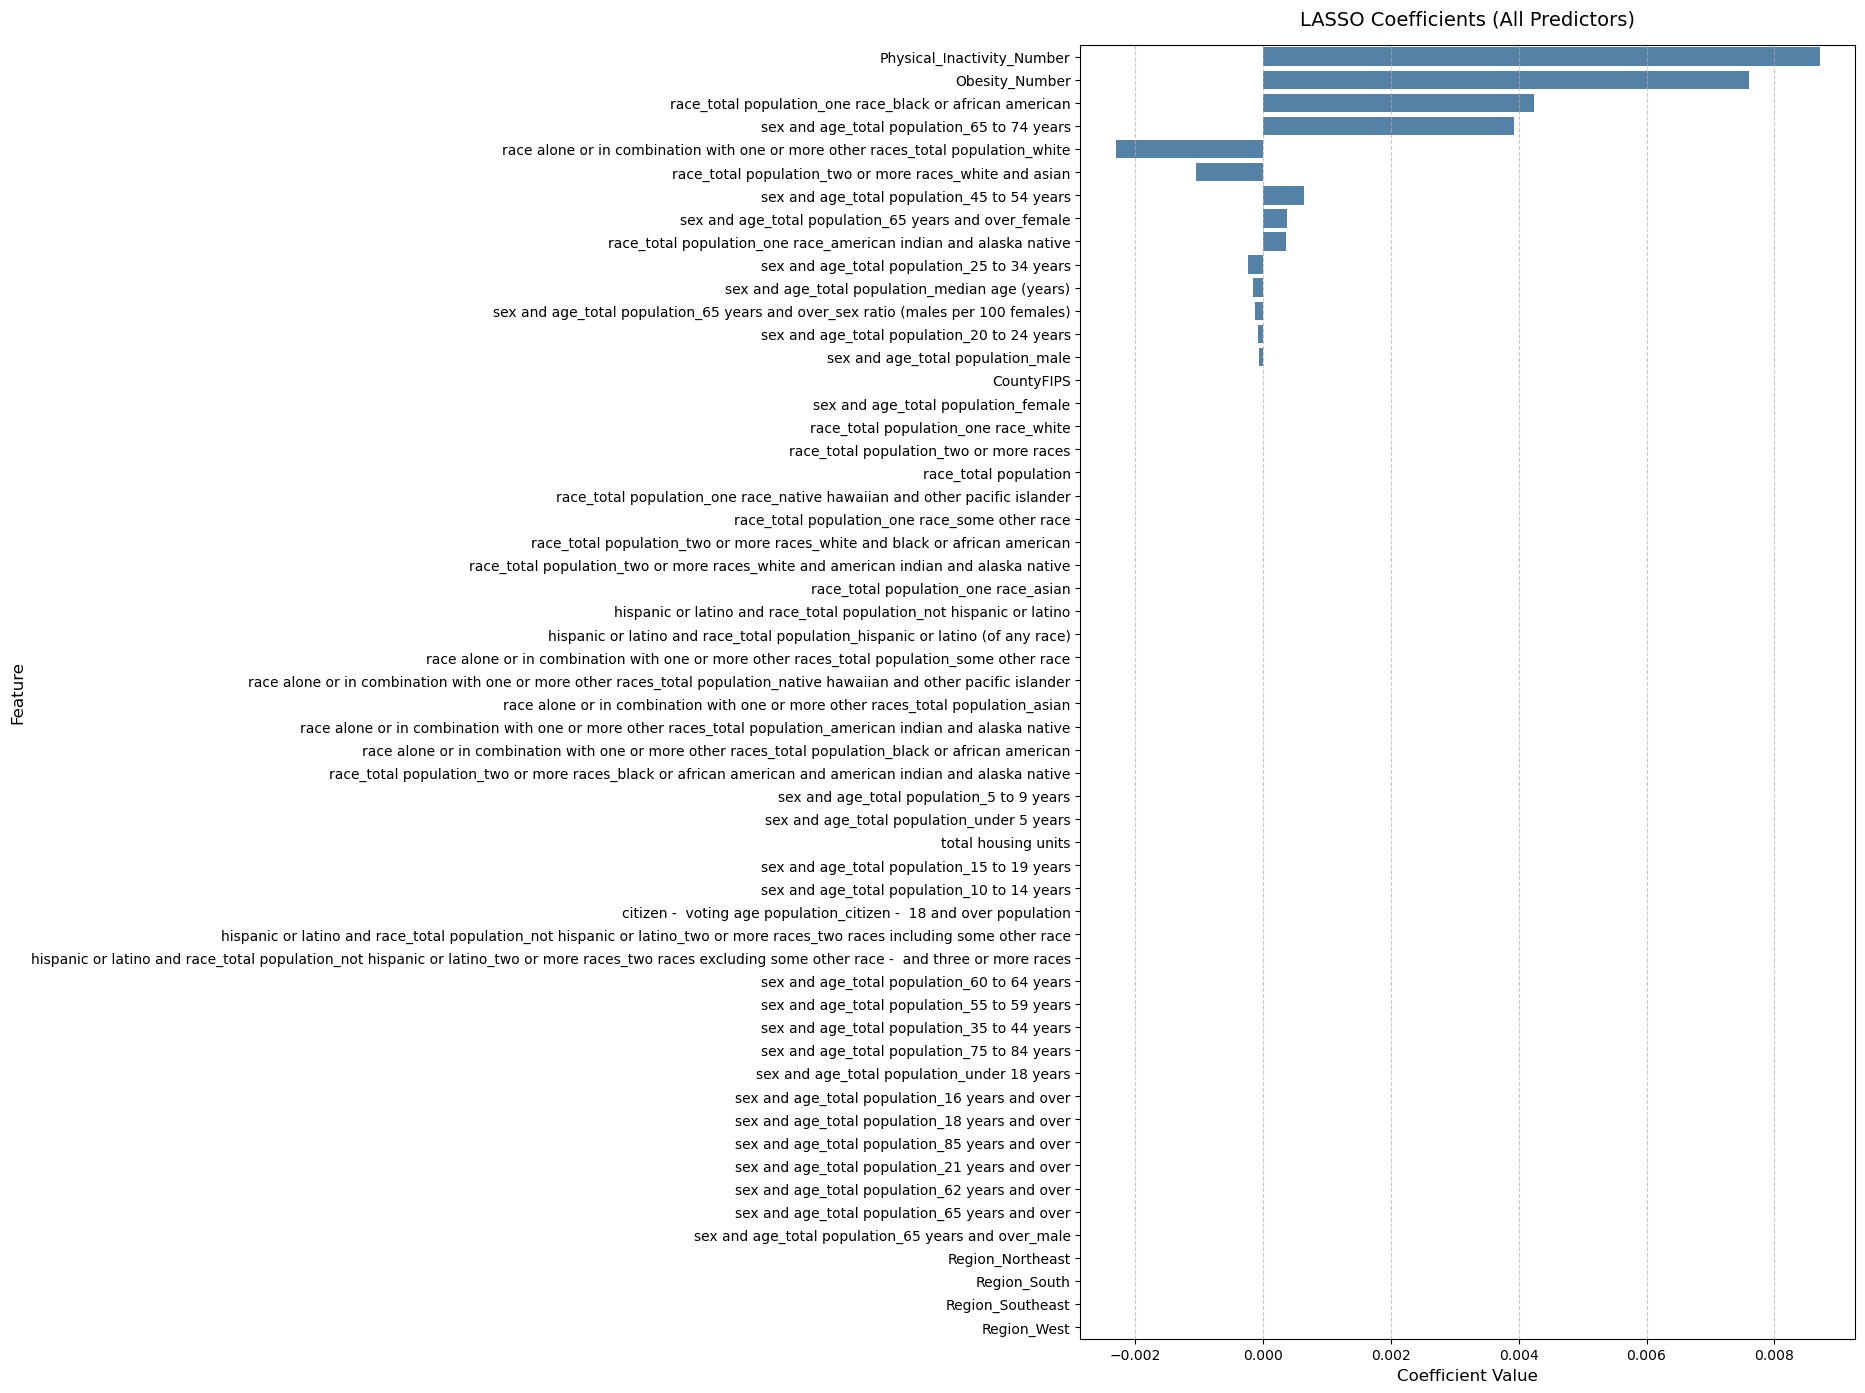

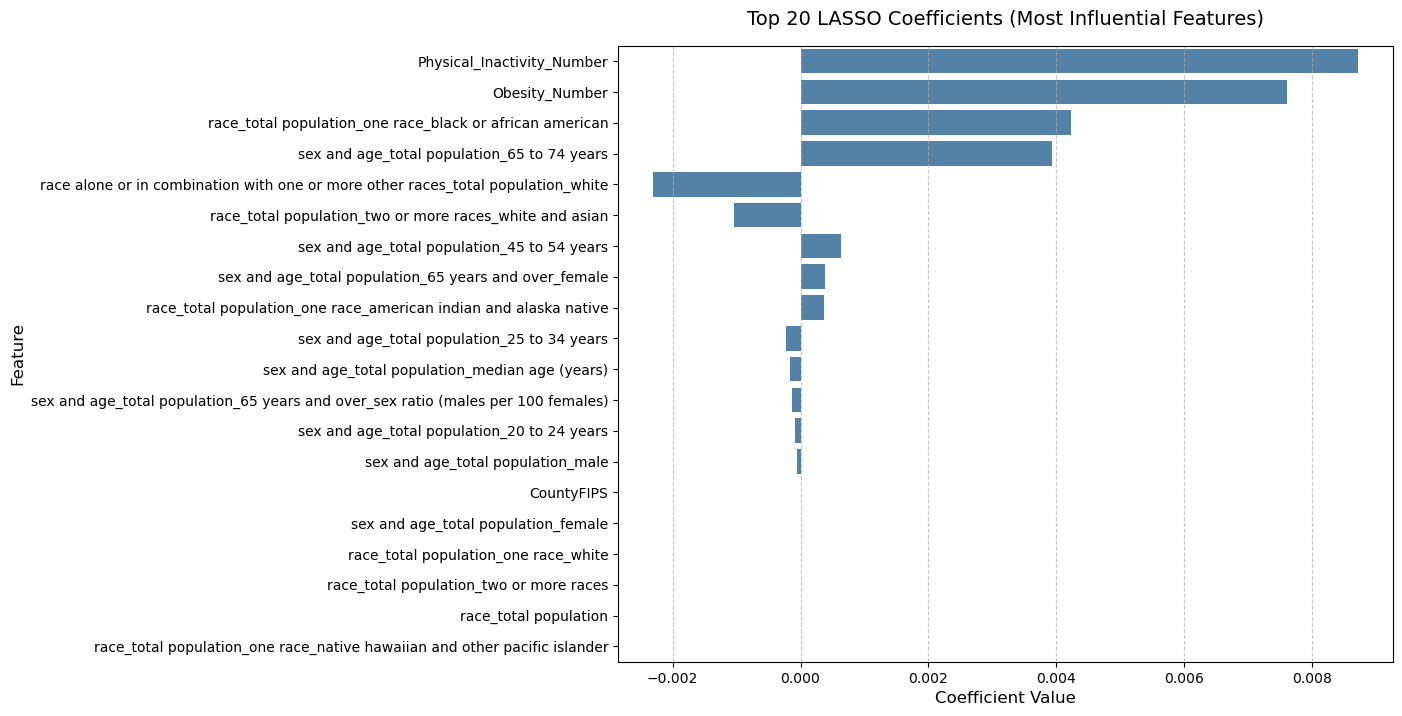

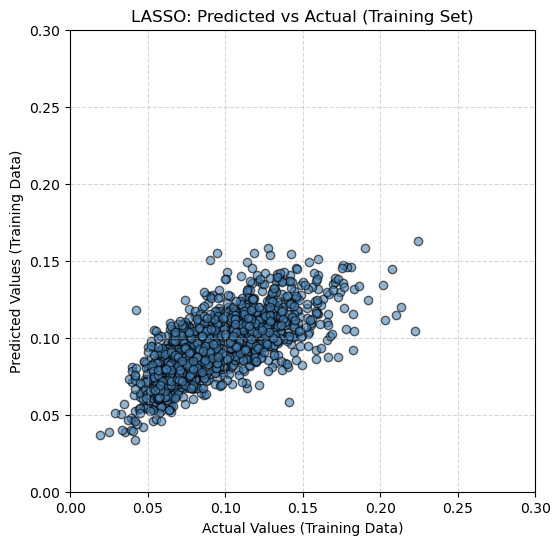


LASSO Regression (Training Set):
R²: 0.4983
RMSE: 0.0205


In [68]:
# -----------------------------------------------------------
# LASSO REGRESSION (L1 REGULARIZATION)
# -----------------------------------------------------------

# Initializing the LASSO model (small alpha per assignment note)
lasso_reg = Lasso(alpha=0.001, max_iter=15000)  

# Fitting the model using the training data.
lasso_model = lasso_reg.fit(X_train, y_train)

# Creating a DataFrame that pairs each feature name with its corresponding coefficient
print("\n--- LASSO Regression Coefficients ---")
lasso_reg_data = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})

# --------------- Visualising Coefficients --------------- 

# Sorting Values by Magnitude (Abs)
lasso_reg_data = lasso_reg_data.sort_values(by="Coefficient", key=abs, ascending=False)

# Dynamic height so all features are visible
plot_height = max(6, 0.3 * len(lasso_reg_data))
plt.figure(figsize=(10, plot_height))

ax = sns.barplot(
    x="Coefficient",
    y="Feature",
    data=lasso_reg_data,
    color="steelblue"
)
ax.set_title("LASSO Coefficients (All Predictors)", fontsize=14, pad=15)
ax.set_xlabel("Coefficient Value", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Plotting a second graph with Top 20 coefficients for readibility and to see the most influential features 
plt.figure(figsize=(10, 8))
sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data.head(20), color="steelblue")
plt.title("Top 20 LASSO Coefficients (Most Influential Features)", fontsize=14, pad=15)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ----- Summary Statistics -----
y_train_pred_lasso = lasso_model.predict(X_train)

# Training scatter: predicted vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_train_pred_lasso, color='steelblue', alpha=0.6, edgecolor='k')
plt.title('LASSO: Predicted vs Actual (Training Set)')
plt.xlabel('Actual Values (Training Data)')
plt.ylabel('Predicted Values (Training Data)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim (0, 0.3)
plt.ylim (0, 0.3)
plt.show()

# Training metrics
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
print("\nLASSO Regression (Training Set):")
print("R²:", round(r2_train_lasso, 4))
print("RMSE:", round(rmse_train_lasso, 4))



In [69]:

training_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'LASSO Regression'],
    'Train R²': [r2_train_lin, r2_train_ridge, r2_train_lasso],
    'Train RMSE': [rmse_train_lin, rmse_train_ridge, rmse_train_lasso]
})

print("\nTraining Set Summary Statistics:")
print(training_summary)



Training Set Summary Statistics:
               Model  Train R²  Train RMSE
0  Linear Regression  0.534520    0.019713
1   Ridge Regression  0.533981    0.019724
2   LASSO Regression  0.498321    0.020465


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [70]:
# MOHAMMED
# Predict on validation data
#-----------

# Linear Regression
y_val_pred_lin = lin_model.predict(X_validate)
r2_val_lin = r2_score(y_validate, y_val_pred_lin)
rmse_val_lin = np.sqrt(mean_squared_error(y_validate, y_val_pred_lin))

# Ridge Regression
y_val_pred_ridge = ridge_model.predict(X_validate)
r2_val_ridge = r2_score(y_validate, y_val_pred_ridge)
rmse_val_ridge = np.sqrt(mean_squared_error(y_validate, y_val_pred_ridge))

# LASSO Regression
y_val_pred_lasso = lasso_model.predict(X_validate)
r2_val_lasso = r2_score(y_validate, y_val_pred_lasso)
rmse_val_lasso = np.sqrt(mean_squared_error(y_validate, y_val_pred_lasso))

validation_summary = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'LASSO Regression'],
    'Val R²': [r2_val_lin, r2_val_ridge, r2_val_lasso],
    'Val RMSE': [rmse_val_lin, rmse_val_ridge, rmse_val_lasso]
})

print("\nValidation Set Summary Statistics:")
print(validation_summary)


Validation Set Summary Statistics:
               Model    Val R²  Val RMSE
0  Linear Regression  0.423964  0.019753
1   Ridge Regression  0.445164  0.019386
2   LASSO Regression  0.452069  0.019265


##### **Model Evaluation:**

From the three models, we observe LASSO Regression performed the best because it has the highest R-squared at 0.452069, meaning that our model explains about 45.2% of the variance in the validation set. Ridge is slightly less accurate, followed by OLS regression. As we said before, LASSO adds an L1 penalty, which shrinks less useful coefficients to zero, and thus reduces overfitting compared to our OLS model.

The model performance is relatively similar across the three models, however they got there in very different ways. All three models tended to underpredict the percentage of the population with diabetes based on the data in the dataset. This is apparent on the scatterplots shown above, where points tend to have predicted values less than their observed values. However, the models had very different predictions regarding the features with the largest predictive power, with only LASSO identifying the variables capturing obesity and physical inactivity as key mechanisms while OLS assigned high coefficient values to demographic variables and Ridge took geographical region more into consideration. The fact that LASSO was more harmonized with the theory around the root causes of diabetes compared to the other models instills confidence in that ML method for this use case.

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [71]:
# MOHAMMED
# Predict using your best model, limit the data to only important features

X_test_selected = X_test[
    [
        'Physical_Inactivity_Number',
        'Obesity_Number',
        'race_total population_one race_black or african american',
        'sex and age_total population_65 to 74 years',
        'race alone or in combination with one or more other races_total population_white',
        'race_total population_two or more races_white and asian',
        'sex and age_total population_45 to 54 years',
        'sex and age_total population_65 years and over_female',
        'race_total population_one race_american indian and alaska native',
        'sex and age_total population_25 to 34 years',
        'sex and age_total population_median age (years)',
        'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
        'sex and age_total population_20 to 24 years',
        'sex and age_total population_male',
        'CountyFIPS',
        'sex and age_total population_female',
    ]
]

X_train_selected = X_train[
    [
        'Physical_Inactivity_Number',
        'Obesity_Number',
        'race_total population_one race_black or african american',
        'sex and age_total population_65 to 74 years',
        'race alone or in combination with one or more other races_total population_white',
        'race_total population_two or more races_white and asian',
        'sex and age_total population_45 to 54 years',
        'sex and age_total population_65 years and over_female',
        'race_total population_one race_american indian and alaska native',
        'sex and age_total population_25 to 34 years',
        'sex and age_total population_median age (years)',
        'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
        'sex and age_total population_20 to 24 years',
        'sex and age_total population_male',
        'CountyFIPS',
        'sex and age_total population_female',
    ]
]

X_validate_selected = X_validate[
    [
        'Physical_Inactivity_Number',
        'Obesity_Number',
        'race_total population_one race_black or african american',
        'sex and age_total population_65 to 74 years',
        'race alone or in combination with one or more other races_total population_white',
        'race_total population_two or more races_white and asian',
        'sex and age_total population_45 to 54 years',
        'sex and age_total population_65 years and over_female',
        'race_total population_one race_american indian and alaska native',
        'sex and age_total population_25 to 34 years',
        'sex and age_total population_median age (years)',
        'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
        'sex and age_total population_20 to 24 years',
        'sex and age_total population_male',
        'CountyFIPS',
        'sex and age_total population_female',
    ]
]

X_validate_selected.head()

Physical_Inactivity_Number  Obesity_Number  \
2122                   -0.563686        0.144941   
1182                   -0.588309       -0.066203   
1232                    0.206786        1.040877   
2871                    0.373483       -1.895188   
2799                   -0.058540       -0.667666   

      race_total population_one race_black or african american  \
2122                                          -0.424247          
1182                                          -0.542958          
1232                                          -0.103597          
2871                                          -0.599618          
2799                                          -0.199528          

      sex and age_total population_65 to 74 years  \
2122                                    -1.328239   
1182                                     0.142788   
1232                                     1.456599   
2871                                     0.412620   
2799                                    -1.282423   

      race alone or in combination with one or more other races_total population_white  \
2122                                           0.447900                                  
1182                                           0.699927                                  
1232                                           0.214132                                  
2871                                           0.689823                                  
2799                                           0.192883                                  

      race_total population_two or more races_white and asian  \
2122                                           1.218127         
1182                                          -0.185827         
1232                                          -0.227210         
2871                                          -0.884286         
2799                                           2.191981         

      sex and age_total population_45 to 54 years  \
2122                                     1.569188   
1182                                     1.023376   
1232                                     0.272964   
2871                                    -2.539289   
2799                                     0.929932   

      sex and age_total population_65 years and over_female  \
2122                                          -1.480596       
1182                                           0.143678       
1232                                           0.965790       
2871                                          -0.837283       
2799                                          -1.463060       

      race_total population_one race_american indian and alaska native  \
2122                                          -0.230779                  
1182                                          -0.200535                  
1232                                           0.122188                  
2871                                          -0.260835                  
2799                                          -0.234511                  

      sex and age_total population_25 to 34 years  \
2122                                     0.534168   
1182                                    -0.161214   
1232                                    -0.538787   
2871                                     0.008599   
2799                                    -0.093401   

      sex and age_total population_median age (years)  \
2122                                        -0.373383   
1182                                        -0.412004   
1232                                         0.182263   
2871                                         1.089719   
2799                                        -0.407608   

      sex and age_total population_65 years and over_sex ratio (males per 100 females)  \
2122                                          -0.477918                                  
1182                                          -0.240594     

In [72]:
#hyperparameter tuning for lasso regression

lasso_reg.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 15000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [73]:
#hyperparametertuning for LASSO before testing 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

lasso_reg = Lasso(max_iter=15000)

param_grid = {
    'alpha': np.arange(0.001, 0.1, 0.005),
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3)
lasso_grid_reg.fit(X_train_selected, y_train)

#Predict on test set using best model
y_test_pred = lasso_grid_reg.best_estimator_.predict(X_test_selected)

# Evaluate test performance
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test RMSE:", rmse(y_test_pred, y_test))

# Evaluate validation performance

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate_selected)

print(lasso_grid_reg.cv_results_["params"][best_index])
print("Best CV R²:", max(lasso_grid_reg.cv_results_["mean_test_score"]))
print("Validation R²:", r2_score(y_validate, best_lasso_pred))
print("Validation RMSE:", rmse(best_lasso_pred, y_validate))

Test R²: 0.4390173081157752
Test RMSE: 0.02064288212034992
{'alpha': np.float64(0.001), 'fit_intercept': True, 'selection': 'cyclic'}
Best CV R²: 0.4888787484685804
Validation R²: 0.45205694190600243
Validation RMSE: 0.01926508907076821


##### **Evaluate prediction on test set:**

The R2 for the prediction on the test set is .439, meaning the model predicted nearly 44% of the variation within the test data. This is close to it's predictive power on the validation dataset, which was an R2 of .452. While the prediction on the validation set was a helpful means of tuning the model's performance, we use the test set at this juncture to ensure that we have unbiased estimate of the model's performance. The usage of both of these sets should instill confidence in you as a policymaker that the results found are not solely a result of overfitting a model to the dataset that we have, meaning the model has predictive power in real-world applications.

### 5.3 Implement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [74]:
X_selected = X[
    [
        'Physical_Inactivity_Number',
        'Obesity_Number',
        'race_total population_one race_black or african american',
        'sex and age_total population_65 to 74 years',
        'race alone or in combination with one or more other races_total population_white',
        'race_total population_two or more races_white and asian',
        'sex and age_total population_45 to 54 years',
        'sex and age_total population_65 years and over_female',
        'race_total population_one race_american indian and alaska native',
        'sex and age_total population_25 to 34 years',
        'sex and age_total population_median age (years)',
        'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
        'sex and age_total population_20 to 24 years',
        'sex and age_total population_male',
        'CountyFIPS',
        'sex and age_total population_female',
    ]
]

In [75]:
# load libraries

from sklearn.model_selection import cross_val_score

lasso_reg = Lasso(max_iter=15000, alpha = .0001) # Had to specify .0001 because .001 caused negative R2 values.

lasso_model = lasso_reg.fit(X_selected, y)

cv_scores = cross_val_score(
    lasso_reg,
    X_selected,
    y,
    cv= 5,               # or whatever k you chose
    scoring='r2'
)

print("CV R² by fold:", cv_scores)
print("Mean CV R²:", cv_scores.mean())
print("Std CV R²:", cv_scores.std())

CV R² by fold: [0.47127082 0.32714857 0.41518312 0.39761016 0.44112262]
Mean CV R²: 0.4104670607912432
Std CV R²: 0.04851055976866087


##### **k Folds Evaluation**

Regarding the k selection, we chose 5 folds to have lower variance in the model performance, giving us a training dataset of 80% of our data, which is even larger than the 60% we used in the train test split. However, because of this, we have higher bias in the estimate of the error. This bias-variance tradeoff inherent in the selection of k. While it is a less efficient use of our small dataset of counties (we could use 90% of observations if we chose k=10) that would risk overfitting our data to that training data and having very little test data. 

Compared to our train/validation/test split, the k-fold analysis performed slightly worse on average. One of the 5 k-fold analyses actually produced a higher R2 than any other analysis, but the next three were the lowest we saw across all three chosen modelling methods using the original train/validate/test data. Additionally, I tested the data with all the features and just the select few: the k folds analysis performed worse than the LASSO model with the X_selected dataset that had fewer features and the X dataset which was used in the first round of modelling and had all features.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**

The bias–variance tradeoff describes the relationship between two types of errors when creating a machine learning model. Bias is the error that comes from making over-simplifying the data in order to arrive at predictions (underfitting). Variance is the error that comes from the model being too sensitive to minor fluctuations or noise in the training data (overfitting). A high-variance model would fit the training data really closely but performs poorly on new data that has different fluctuations. The tradeoff arises because reducing one often increases the other. Adding features / making a model more complex reduces bias but increases variance, while removing features / simplifying it reduces variance but increases bias. The goal is to balance these to find a model that captures the underlying relationship in the data in order to predict well for new data.

Using the dart board analogy, having high variance would mean darts are relatively spread out while having high bias means that darts are always tending to land on the same part of the board away from the bullseye.

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**

Overfitting happens when a machine learning model accounts for the changes in the training data too well, including random noise and outliers, instead of the truly predictive underlying patterns. This would cause the model to perform very well on the training data but poorly on new data because it fails to generalize. Overfitting matters because the ultimate goal of machine learning is to make accurate predictions on new data.

To address overfitting, we can use several techniques. One common approach is to simplify the model, such as using fewer parameters. We can also use regularization methods (like LASSO or Ridge regression), which add a penalty for large coefficients to discourage overly complex models. Cross-validation helps by testing the model on different subsets of data to ensure it performs consistently. Additionally, gathering more training data can help the model learn the general patterns better can reduce overfitting.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**Discussion and Findings:**
The exploratory data analysis provided valuable insight into feature relationships and redundancy. The EDA correlation plot gave us a good indication of the features we expected to be the strongest predictors in what finally turned out to be our best interpretable model (LASSO). The correlation heatmap revealed several cases of perfect or near-perfect collinearity and inverse collinearity among demographic variables, prompting us to remove redundant features. For example, we retained <hispanic or latino and race_total population_hispanic or latino (of any race)> but dropped its highly correlated sub-categories such as <…_mexican>. Similarly, we excluded <race_total population_one race> and retained <race_total population_two or more races due to perfect inverse correlation. These steps helped reduce feature duplication and improve model stability.

**Model Performance and Interpretation:**
During modeling, we observed that many remaining features still exhibited overlap, causing strange coefficient behavior and lowers interpretability—especially for race-related variables such as <race_total population_one race_american indian and alaska native> being important. Among all models, LASSO regression achieved the best validation R² despite lower performance on the training set, suggesting better generalization. Its feature selection capability and penalty on redundant predictors made the model more interpretable in the presence of multicollinearity and aligned better with theoretical causes of diabetes. However, the overall explanatory power remained modest, with R² values below 0.5, indicating that available predictors only partially explain variation in diabetes rates.

**Recommendations and Confidence:**
Based on model insights, counties with high physical inactivity, obesity, older populations, and larger Black populations should be prioritized for pilot interventions. Incorporating race, gender, or age composition slightly adjusts emphasis but does not fundamentally change priority regions. Nevertheless, confidence in deploying this model in a real-world program would be limited due to the dataset’s constraints. While OLS and Ridge models show that regionality may play a role, as South and Southeast are positively correlated, that is not true in LASSO and makes us less confident in recommending a certain geographic focus. Additional variables—such as income data from the Census, the population density of a county (whether it is urban or rural), or medical indicators like blood pressure, BMI, and glucose levels—would likely improve the accuracy of machine learning models and enhance their policy relevance, enabling more reliable and equitable targeting decisions. These additional variables would make us ore comfortable deploying the LASSO model in a real-world application; currently, its R2 of <50% means that it is explaining less than half of the variation in the data and therefore should not be trusted to fully guide policy, though it can inform some real-world efforts.

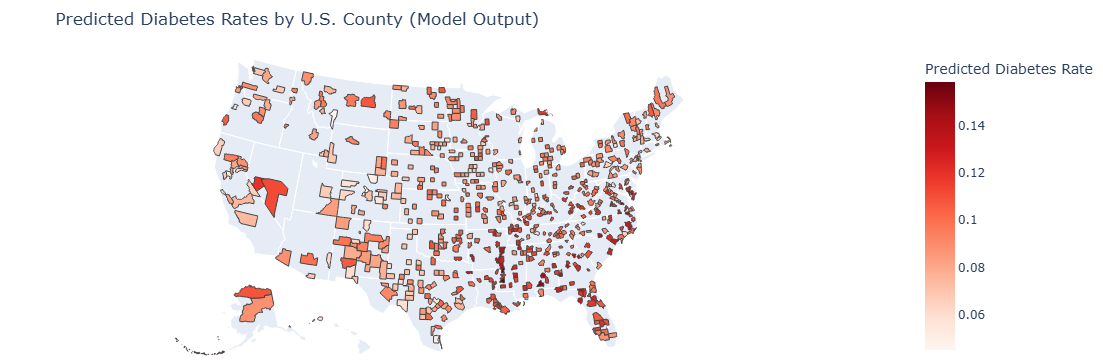

In [76]:
import plotly.express as px


# --- Combine predictions with test data ---
results = X_test.copy()
results["Predicted_Diabetes"] = y_test_pred

# Ensure FIPS codes are strings padded to 5 digits
results["CountyFIPS"] = results["CountyFIPS"].astype(str).str.zfill(5)

# Merge with original county info (for State, Region, etc.)
results = results.merge(
    diabetes[["CountyFIPS", "County", "State", "Region"]],
    on="CountyFIPS",
    how="left"
)

# --- Choropleth of Predicted Diabetes Rates ---
fig = px.choropleth(
    results,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations="CountyFIPS",
    color="Predicted_Diabetes",
    hover_name="County",
    hover_data=["State", "Region"],
    scope="usa",
    color_continuous_scale="Reds",
    labels={"Predicted_Diabetes": "Predicted Diabetes Rate"},
    title="Predicted Diabetes Rates by U.S. County (Model Output)"
)

fig.update_layout(margin={"r":0, "t":50, "l":0, "b":0})
fig.show()

**YOUR ANSWER HERE**...